In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pygrib
import numpy as np
import numba as nb
import pandas as pd
import netCDF4 as nc

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/')

import utils

# !!!! <---- change to your namelist
from namelist_casper import * 
from namelist_plot import *
import plot_lib as plib

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/utils.py'>

In [3]:
importlib.reload(plib)

<module 'plot_lib' from '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/plot_lib.py'>

In [4]:
#importlib.reload(namelist_plot)
from namelist_plot import *

In [5]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [6]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [7]:
dt_fmt = '20220413'
if dt_fmt == 'auto':
    dt_utc_now = datetime.utcnow()
    dt_fmt_string = datetime.strftime(dt_utc_now, '%Y%m%d')
else:
    dt_fmt_string = dt_fmt
    dt_utc_now = datetime.strptime(dt_fmt_string, '%Y%m%d')

In [8]:
with h5py.File(path_domain_namelist, 'r') as h5io:
    lat_bc = h5io['bc_lat'][...] # lats of the BC domain
    lon_bc = h5io['bc_lon'][...] # lons of the BC domain
    lon_4km = h5io['lon_4km'][...]
    lat_4km = h5io['lat_4km'][...]
    land_mask_bc = h5io['land_mask_bc'][...] # selecting OCEAN grids from the BC domain
    land_mask_bc_4km = h5io['land_mask_bc_4km'][...]
# ocean_mask_bc = np.logical_not(land_mask_bc) # selecting LAND grids from the BC domain
grid_shape = lon_bc.shape

In [9]:
output_dir = output_dir_namelist.format(dt_fmt_string)
name_output = filename_CNN_output_namelist.format(dt_fmt_string)

with h5py.File(output_dir+name_output, 'r') as h5io:
    CNN_output = h5io['gefs_apcp'][...]
    
CNN_output[..., land_mask_bc] = np.nan

In [10]:
# def accum_slide_window_stn(data, accum_window, output_freq, skip_start):

#     inds_start = []
#     inds_end = []
    
#     EN, N_lead = data.shape

#     N_output = (N_lead - accum_window - skip_start) // output_freq + 1

#     Accum_output = np.empty((EN, N_output))

#     for n in range(N_output):

#         ind_start = skip_start+n*output_freq
#         ind_end = ind_start+accum_window
#         Accum_output[:, n, ...] = np.nansum(data[:, ind_start:ind_end, ...], axis=1)

#         inds_start.append(ind_start)
#         inds_end.append(ind_end)
        
#     return Accum_output, inds_start, inds_end

In [11]:
# def accum_original_stn(data, accum_window, output_freq, skip_start):

#     inds_start = []
#     inds_end = []
    
#     EN, N_lead = data.shape

#     N_output = (N_lead - accum_window - skip_start) // output_freq + 1

#     Accum_output = np.empty((EN, N_output))

#     for n in range(N_output):

#         ind_start = skip_start+n*output_freq
#         ind_end = ind_start+accum_window
#         Accum_output[:, n, ...] = np.nansum(data[:, ind_start:ind_end, ...], axis=1)

#         inds_start.append(ind_start)
#         inds_end.append(ind_end)
        
#     return Accum_output, inds_start, inds_end

In [12]:
stn_names = list(STN_LOCs.keys())
stn_lons = []
stn_lats = []

for stn in stn_names:
    stn_lons.append(STN_LOCs[stn][0])
    stn_lats.append(STN_LOCs[stn][1])
    
stn_lons = np.array(stn_lons)
stn_lats = np.array(stn_lats)

In [13]:
indx, indy = utils.grid_search(lon_bc, lat_bc, stn_lons, stn_lats)
L_stn = len(stn_names)

Qs = [0.1, 0.25, 0.5, 0.75, 0.9]
Qs_str = ['P10', 'P25', 'P50', 'P75', 'P90']
COLORS = [plib.xcolor('light steel blue'), plib.xcolor('corn flower blue'), plib.xcolor('slate blue')]

LEADs_3H_ind = np.arange(0, N_leads_namelist, dtype=np.int)
LEADs_3H_hrs = np.arange(9.0, 24*7+3, 3)[:N_leads_namelist]

In [14]:
STN_LOCs

{'BCK': (-123.91388888888889, 48.50333333333333),
 'CMX': (-125.09444444444443, 49.643055555555556),
 'COQ': (-122.77777777777777, 49.355555555555554),
 'CRS': (-116.51666666666667, 49.1),
 'ELK': (-125.76416666666667, 49.87277777777778),
 'PYN': (-122.6375, 55.35),
 'STA': (-122.32638888888889, 49.5575),
 'WAH': (-121.61861111111111, 49.231944444444444),
 'WON': (-121.8, 56.733333333333334),
 'YRV': (-118.18333333333334, 50.96666666666667),
 'YVR': (-123.18333333333334, 49.18333333333333),
 'YXJ': (-120.73333333333333, 56.233333333333334),
 'ING': (-125.11, 56.72),
 'DLU': (-123.1672, 50.86)}

In [15]:
# def plot_stn(DATA, fcst_hrs, accums, accum_strs, dt_utc_now, stn_name, COLORS, font_text):
# #     PDT    
# #     utc_converter = pytz.utc
# #     dt_utc_now = utc_converter.localize(dt_utc_now)
# #     dt_utc_now = dt_utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    
#     dt_utc_now = dt_utc_now-timedelta(hours=8)
#     dt_ini_str = datetime.strftime(dt_utc_now, '%Y-%h-%d %H00 PST (-8 UTC)')
    
#     fig = plt.figure(figsize=(18, 42), dpi=70)#fig_keys['dpi']
#     gs = gridspec.GridSpec(7, 1, height_ratios=[1, 1, 1, 1, 1, 1, 1])
#     ax1 = plt.subplot(gs[0, 0])
#     ax2 = plt.subplot(gs[1, 0])
#     ax3 = plt.subplot(gs[2, 0])
#     ax4 = plt.subplot(gs[3, 0])
#     ax5 = plt.subplot(gs[4, 0])
#     ax6 = plt.subplot(gs[5, 0])
#     ax7 = plt.subplot(gs[6, 0])
    
#     AX = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    
#     plt.subplots_adjust(0, 0, 1, 1, hspace=0.4, wspace=0)
    
#     # ===== Text ===== #
    
#     handle_title = []
#     AX_text_order = []
#     gap = 0.14285+0.00625 #0.176
#     for i in range(7):
#         ax_temp = fig.add_axes([0.01, 0.99-i*gap, 0.375, 0.006], facecolor='w')
#         [j.set_linewidth(0.0) for j in ax_temp.spines.values()]
        
#         ax_temp.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
#                             labelleft=False, labeltop=False, labelright=False, labelbottom=False)
#         AX_text_order.append(ax_temp)

#     AX_text = AX_text_order
#     # ===== Bars ===== #
    
    
#     STEPs = [3, 24]
#     # ---------- 3 hrs ---------- #
#     i = 0
#     ax = AX[i]
#     accum = accums[i]
#     accum_str = accum_strs[i]
#     fcst_hr = fcst_hrs[i]
        
#     ax = plib.ax_decorate_box(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
#     ax.grid(linestyle=':', color='k'); ax.xaxis.grid(False)
        
#     dt_valid = []
#     for hrs in fcst_hr:
#         dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs), '%H00 %d %h'))
    
#     for l, temp_h in enumerate(fcst_hr):
#         # ((bottom left), width, height)
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_min'.format(accum)][l]), STEPs[i], DATA['CNN_{}_max'.format(accum)][l], facecolor=COLORS[0], edgecolor='0.5', linewidth=1.5))
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_P10'.format(accum)][l]), STEPs[i], DATA['CNN_{}_P90'.format(accum)][l], facecolor=COLORS[1], edgecolor='0.5', linewidth=1.5))
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_P25'.format(accum)][l]), STEPs[i], DATA['CNN_{}_P75'.format(accum)][l], facecolor=COLORS[2], edgecolor='0.5', linewidth=1.5))
#         ax.hlines(y=DATA['CNN_{}_P50'.format(accum)][l], xmin=temp_h, xmax=temp_h, color='k', linestyle='--', linewidth=2.5);
            
#     ax.set_xticks(fcst_hr);
#     ax.set_xticklabels(dt_valid, rotation='90');
#     ax.set_xlim([fcst_hrs[0][0]-6, fcst_hrs[0][-1]+3]);
    
#     # ---------- 24 hrs ---------- #
#     i = 1
#     ax = AX[i]
#     accum = accums[i]
#     accum_str = accum_strs[i]
#     fcst_hr = fcst_hrs[i]
        
#     ax = plib.ax_decorate_box(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
#     ax.grid(linestyle=':', color='k'); ax.xaxis.grid(False)
        
#     dt_valid = []
#     for hrs in fcst_hr:
#         dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs-STEPs[i]), '%d %h'))
        
#     for l, temp_h in enumerate(fcst_hr):
#         # ((bottom left), width, height)
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_min'.format(accum)][l]), STEPs[i], DATA['CNN_{}_max'.format(accum)][l], facecolor=COLORS[0], edgecolor='0.5', linewidth=1.5))
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_P10'.format(accum)][l]), STEPs[i], DATA['CNN_{}_P90'.format(accum)][l], facecolor=COLORS[1], edgecolor='0.5', linewidth=1.5))
#         ax.add_patch(patches.Rectangle((temp_h-STEPs[i], DATA['CNN_{}_P25'.format(accum)][l]), STEPs[i], DATA['CNN_{}_P75'.format(accum)][l], facecolor=COLORS[2], edgecolor='0.5', linewidth=1.5))
#         ax.hlines(y=DATA['CNN_{}_P50'.format(accum)][l], xmin=temp_h-STEPs[i], xmax=temp_h, color='k', linestyle='--', linewidth=2.5);
            
#     ax.set_xticks(fcst_hr-0.5*STEPs[i]);
#     ax.set_xticklabels(dt_valid, rotation='90');
#     ax.set_xlim([fcst_hrs[0][0]-6, fcst_hrs[0][-1]+3]);
        
#     # ===== Lines ===== #
#     for i in range(2, 7, 1):
#         ax = AX[i]
#         accum = accums[i]
#         accum_str = accum_strs[i]
#         fcst_hr = fcst_hrs[i]
        
#         ax = plib.ax_decorate_box(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
#         ax.grid(linestyle=':', color='k'); ax.xaxis.grid(True)
        
#         dt_valid = []
#         for hrs in fcst_hr:
#             dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs), '%H00 %d %h'))
        
#         ax.fill_between(fcst_hr, DATA['CNN_{}_min'.format(accum)], DATA['CNN_{}_max'.format(accum)], color=COLORS[0])
#         ax.fill_between(fcst_hr, DATA['CNN_{}_P10'.format(accum)], DATA['CNN_{}_P90'.format(accum)], color=COLORS[1])
#         ax.fill_between(fcst_hr, DATA['CNN_{}_P25'.format(accum)], DATA['CNN_{}_P75'.format(accum)], color=COLORS[2])
#         handle_line = ax.plot(fcst_hr, DATA['CNN_{}_P50'.format(accum)], 'k--', lw=2.5, label='50th');
        
#         ax.set_xticks(fcst_hr);
#         ax.set_xticklabels(dt_valid, rotation='90');
#         ax.set_xlim([fcst_hrs[0][0]-6, fcst_hrs[0][-1]+3]);
    
#     # ===== Ticks & Legend ===== #
#     for i in range(7):
#         ax = AX[i]
#         accum = accums[i]
#         accum_str = accum_strs[i]
#         fcst_hr = fcst_hrs[i]
#         ax.set_ylim([0, 0.5+np.nanmax(DATA['CNN_{}_max'.format(accum)])*1.25])
#         #ax.set_xlabel('Valid time (accumulated hours backward)', fontsize=font_text);
#         ax.set_ylabel('[mm]', fontsize=font_text);
        
#     for i in [0, 1, -1]:
        
#         handle_title += plib.string_partial_format(fig, AX_text[i], 0, 1, 'left', 'top',
#                                                    ['Post-processed GEFS ', accum_strs[i], ' total precipitation ensemble at ', stn_name, '. Initialization time: ', dt_ini_str],
#                                                    ['k',]*6, [font_text+2,]*6, ['normal', 'bold', 'normal', 'bold', 'normal', 'normal'])
        
#     for i in range(2, 6, 1):
        
#         handle_title += plib.string_partial_format(fig, AX_text[i], 0, 1, 'left', 'top',
#                                                    ['Post-processed GEFS accumulated total precipitation ensemble ', accum_strs[i], ', at ', stn_name, '. Initialization time: ', dt_ini_str],
#                                                    ['k',]*6, [font_text+2,]*6, ['normal', 'bold', 'normal', 'bold', 'normal', 'normal'])
        
#     for handle in handle_title:
#         handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=0.0, zorder=6))
        
#     handle_legneds = []
#     handle_legneds.append(patches.Patch(facecolor=COLORS[0], edgecolor='k', linewidth=0, label='min - max'))
#     handle_legneds.append(patches.Patch(facecolor=COLORS[1], edgecolor='k', linewidth=0, label='10th - 90th'))
#     handle_legneds.append(patches.Patch(facecolor=COLORS[2], edgecolor='k', linewidth=0, label='25th - 75th'))


    
#     ax_lg2 = fig.add_axes([1.0, 1.0-0.04, 0.11, 0.04])
#     ax_lg2.set_axis_off()
#     LG2 = ax_lg2.legend(handles=handle_legneds+handle_line, bbox_to_anchor=(0.0, 0.5), ncol=1, loc=6, prop={'size':font_text}, fancybox=False);
#     LG2.get_frame().set_facecolor('w')
#     LG2.get_frame().set_linewidth(2.0)
#     LG2.get_frame().set_alpha(1.0)

In [17]:
# png_stn_name = {}
# png_stn_name['base_'] = '{}.BCHGRD1.pcp.png'
# #png_stn_name['dir'] = '/oper_data/NowCastingML/example_output/'
# png_stn_name['dir'] = '/www/results/BCHGRD1/%y%m%d00/PNG/g2/'

In [18]:
# output_dir = png_stn_name['dir']+png_stn_name['base_'].format(stn_name)
# output_dir_now =  datetime.strftime(dt_utc_now, output_dir)

In [19]:
# output_dir_now

'/www/results/BCHGRD1/22041300/PNG/g2/DLU.BCHGRD1.pcp.png'

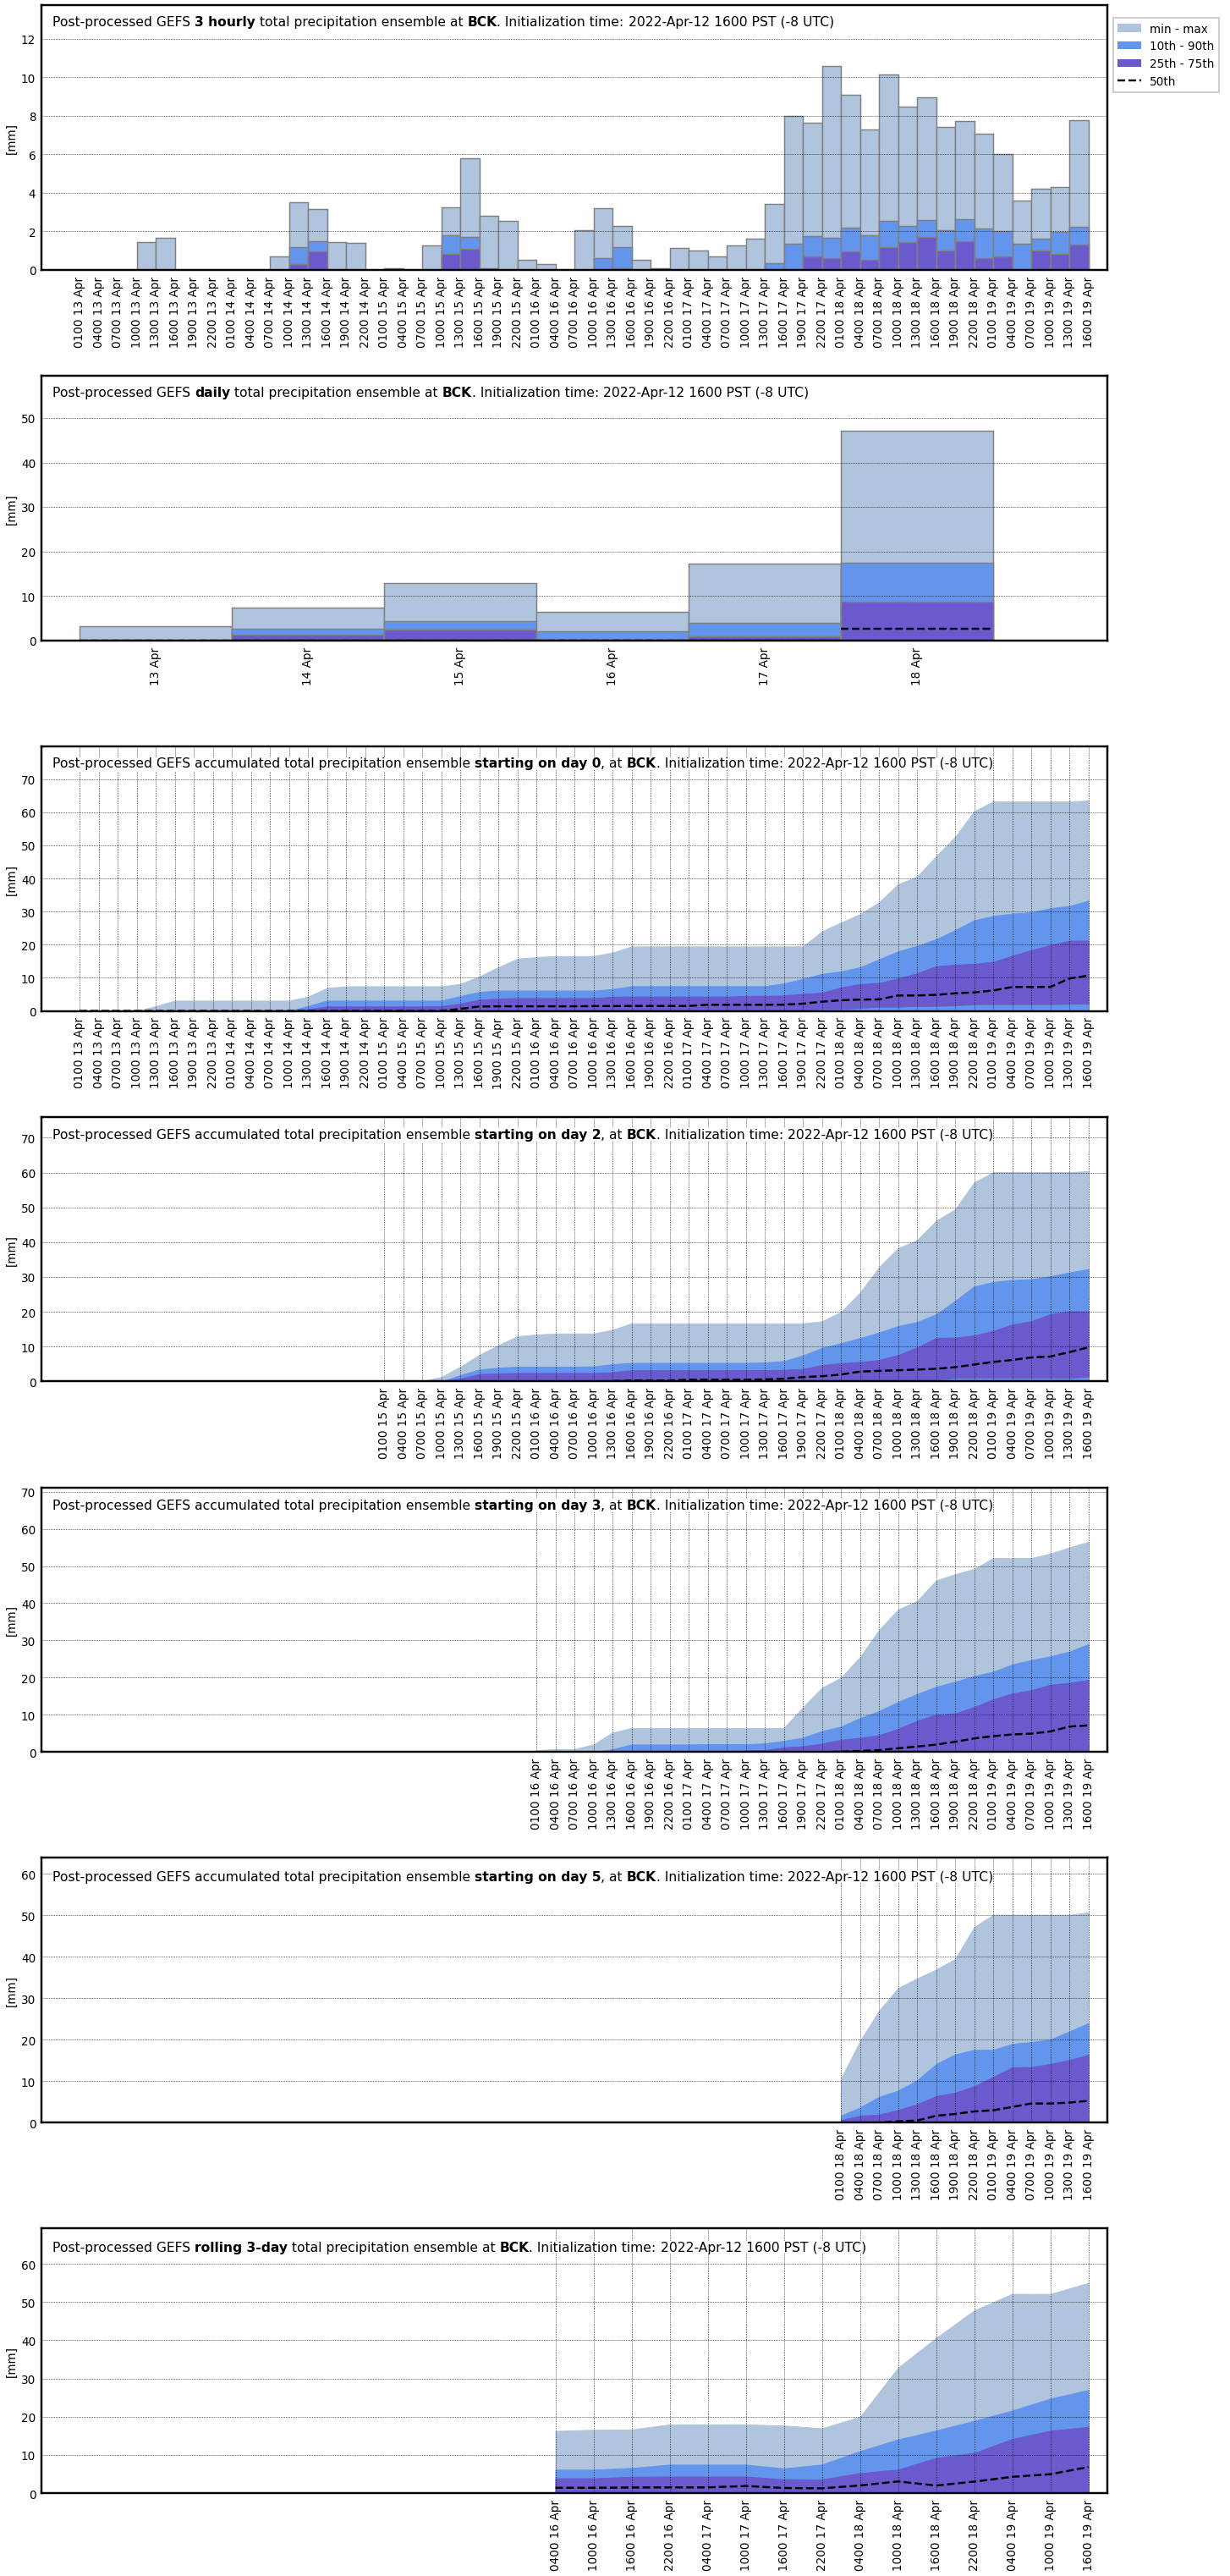

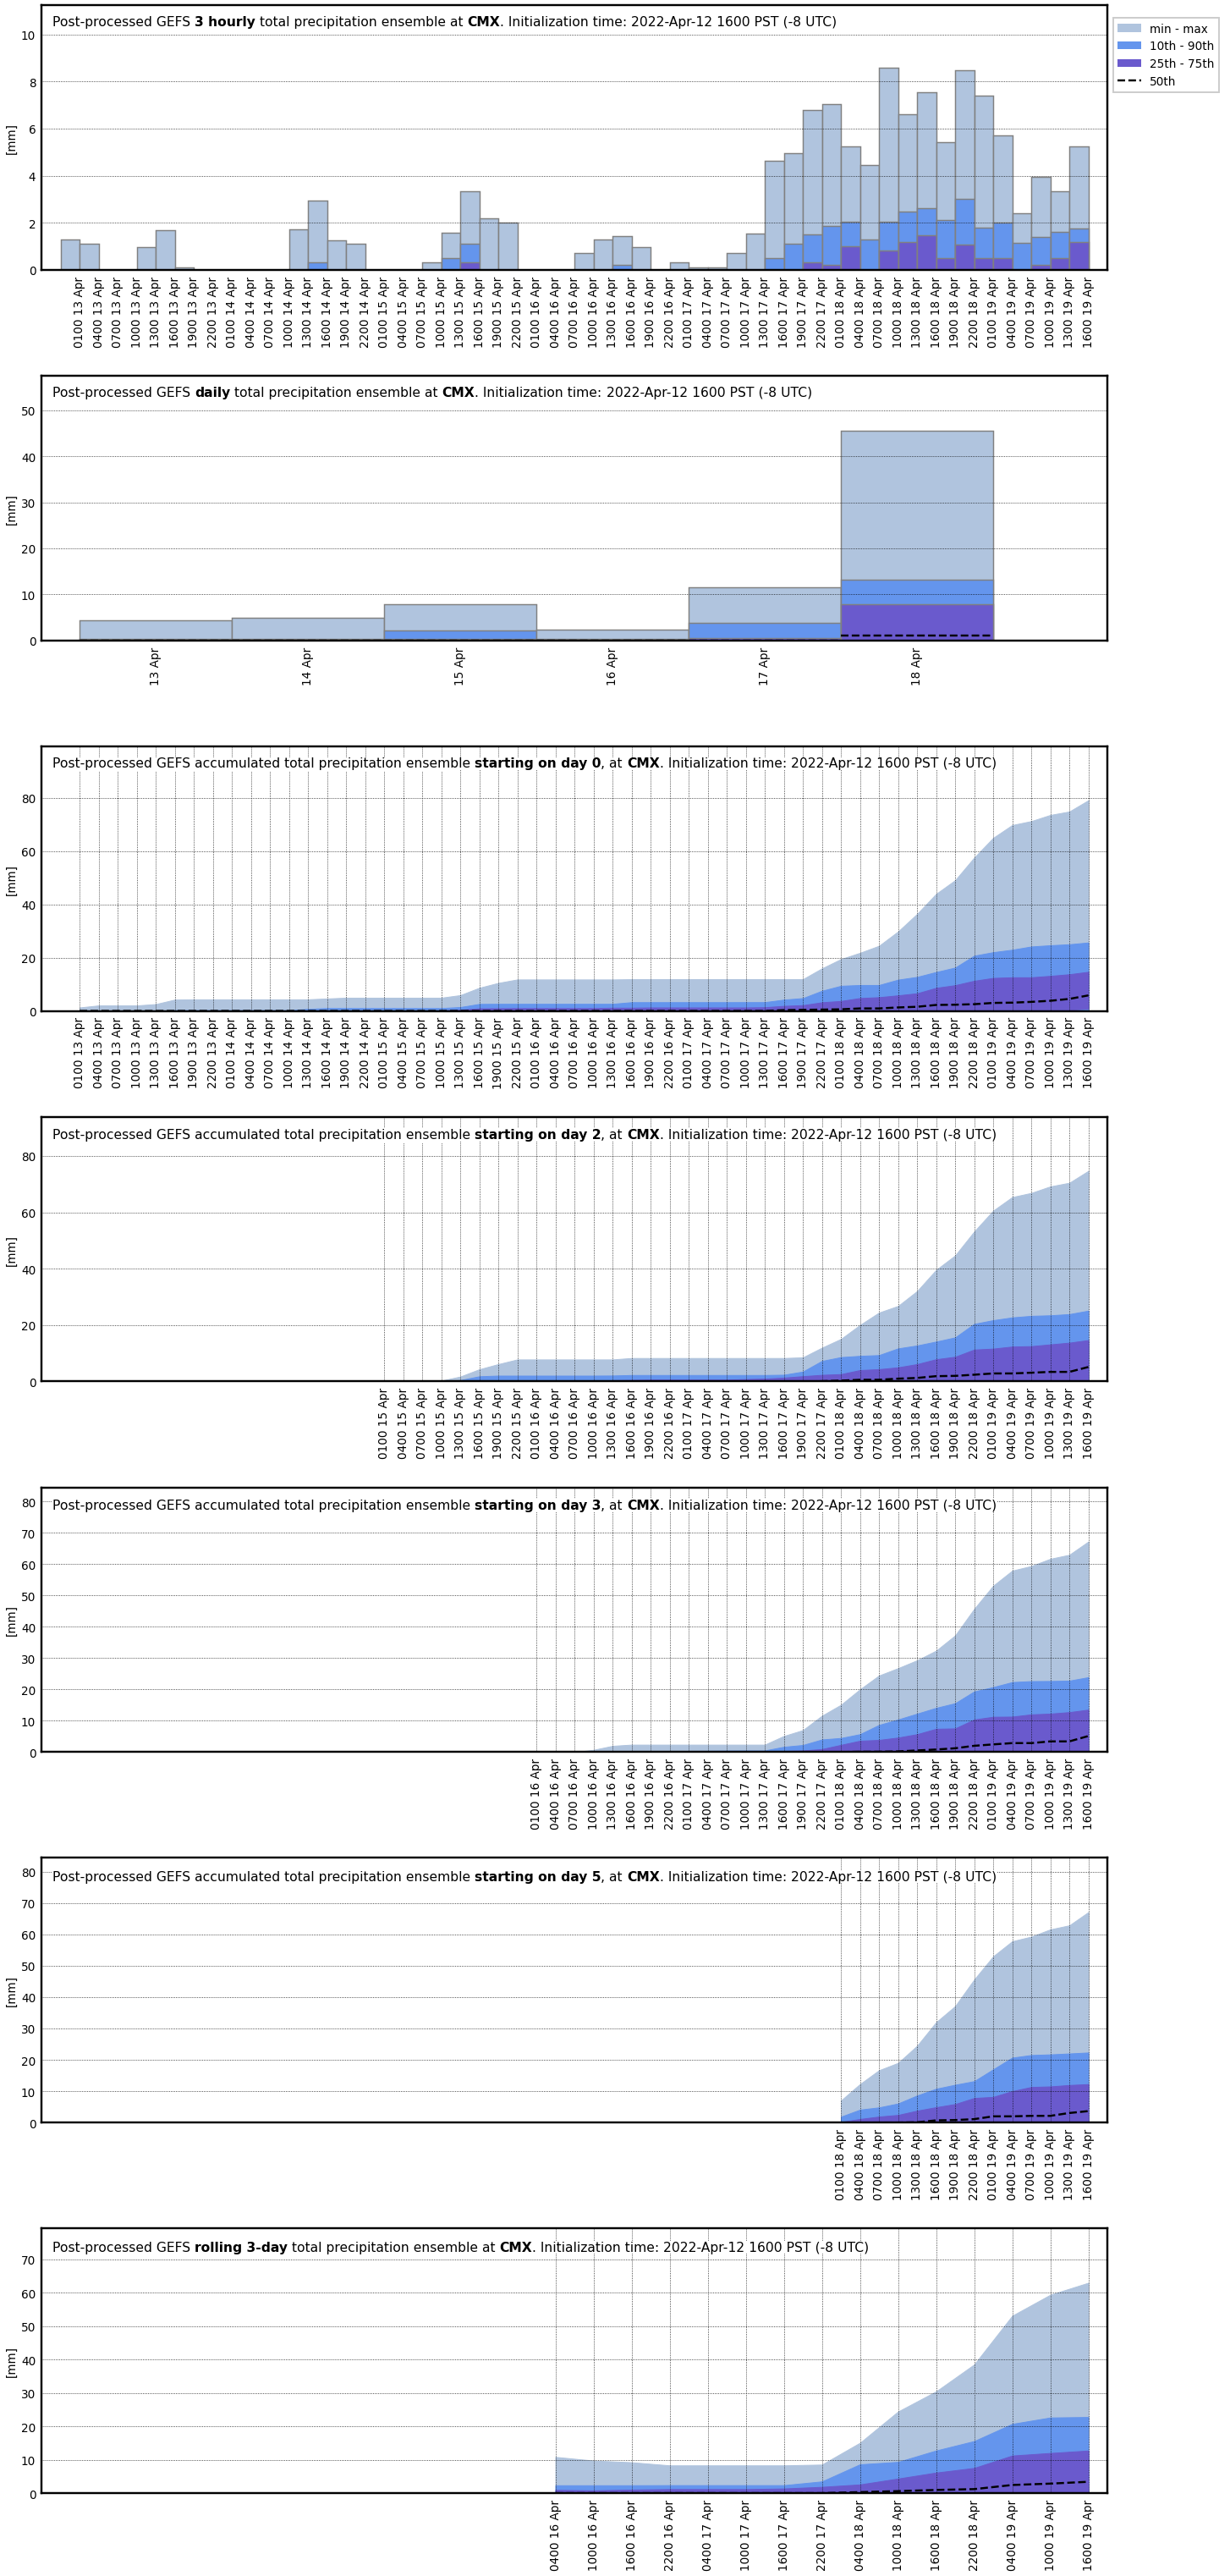

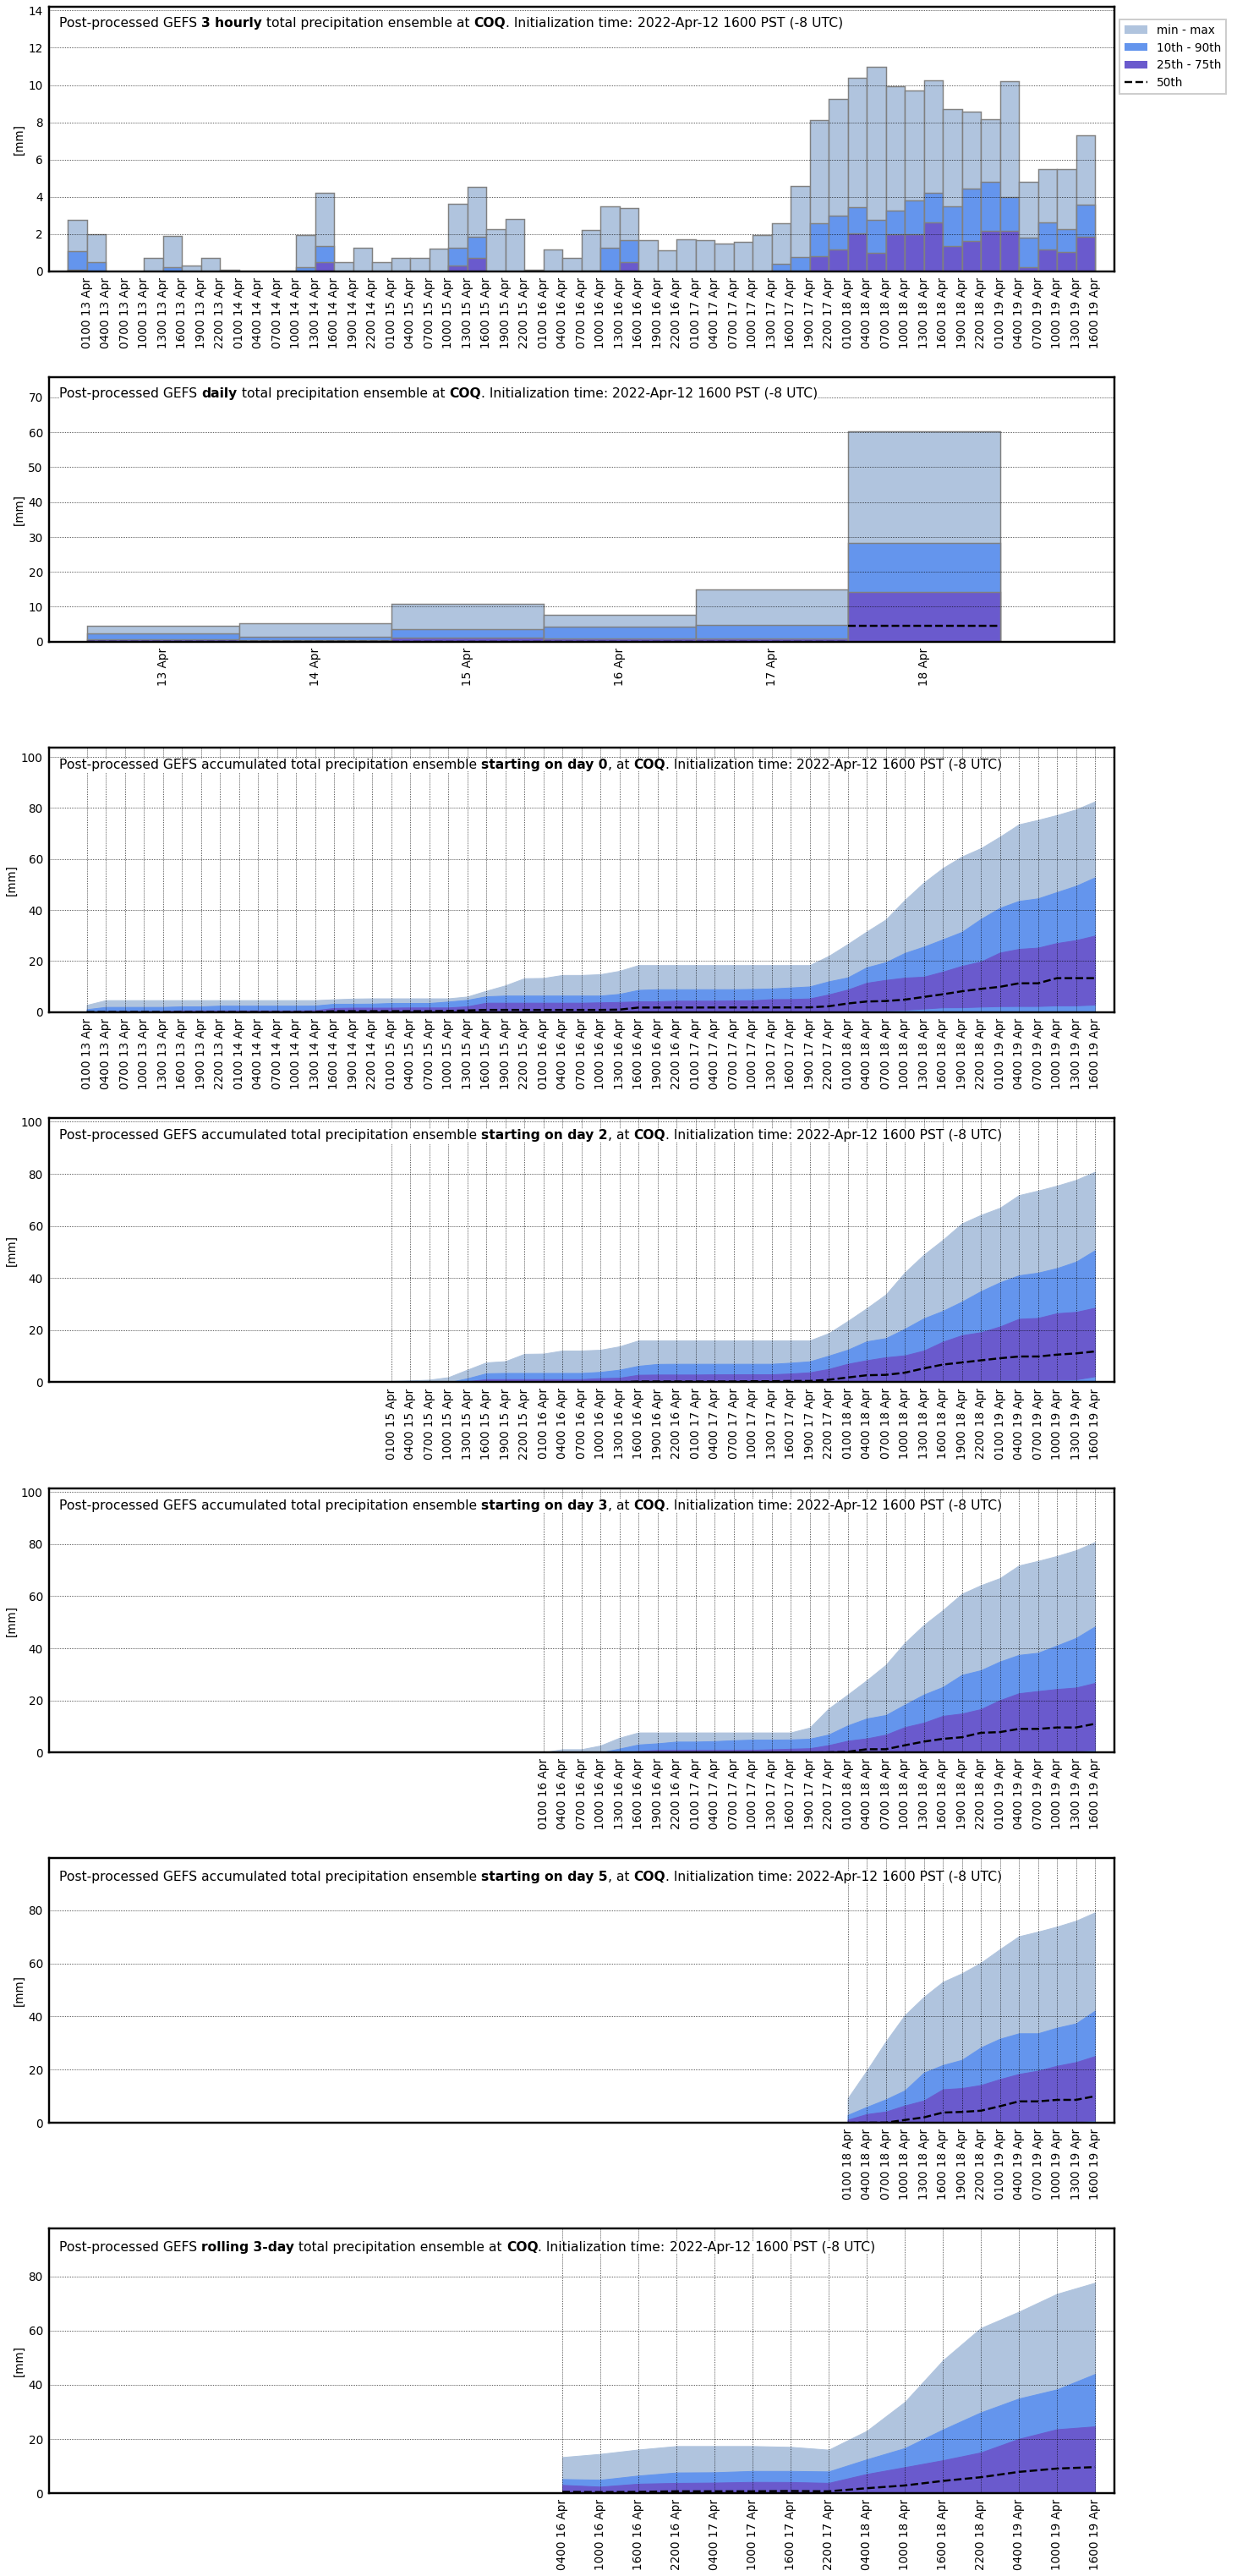

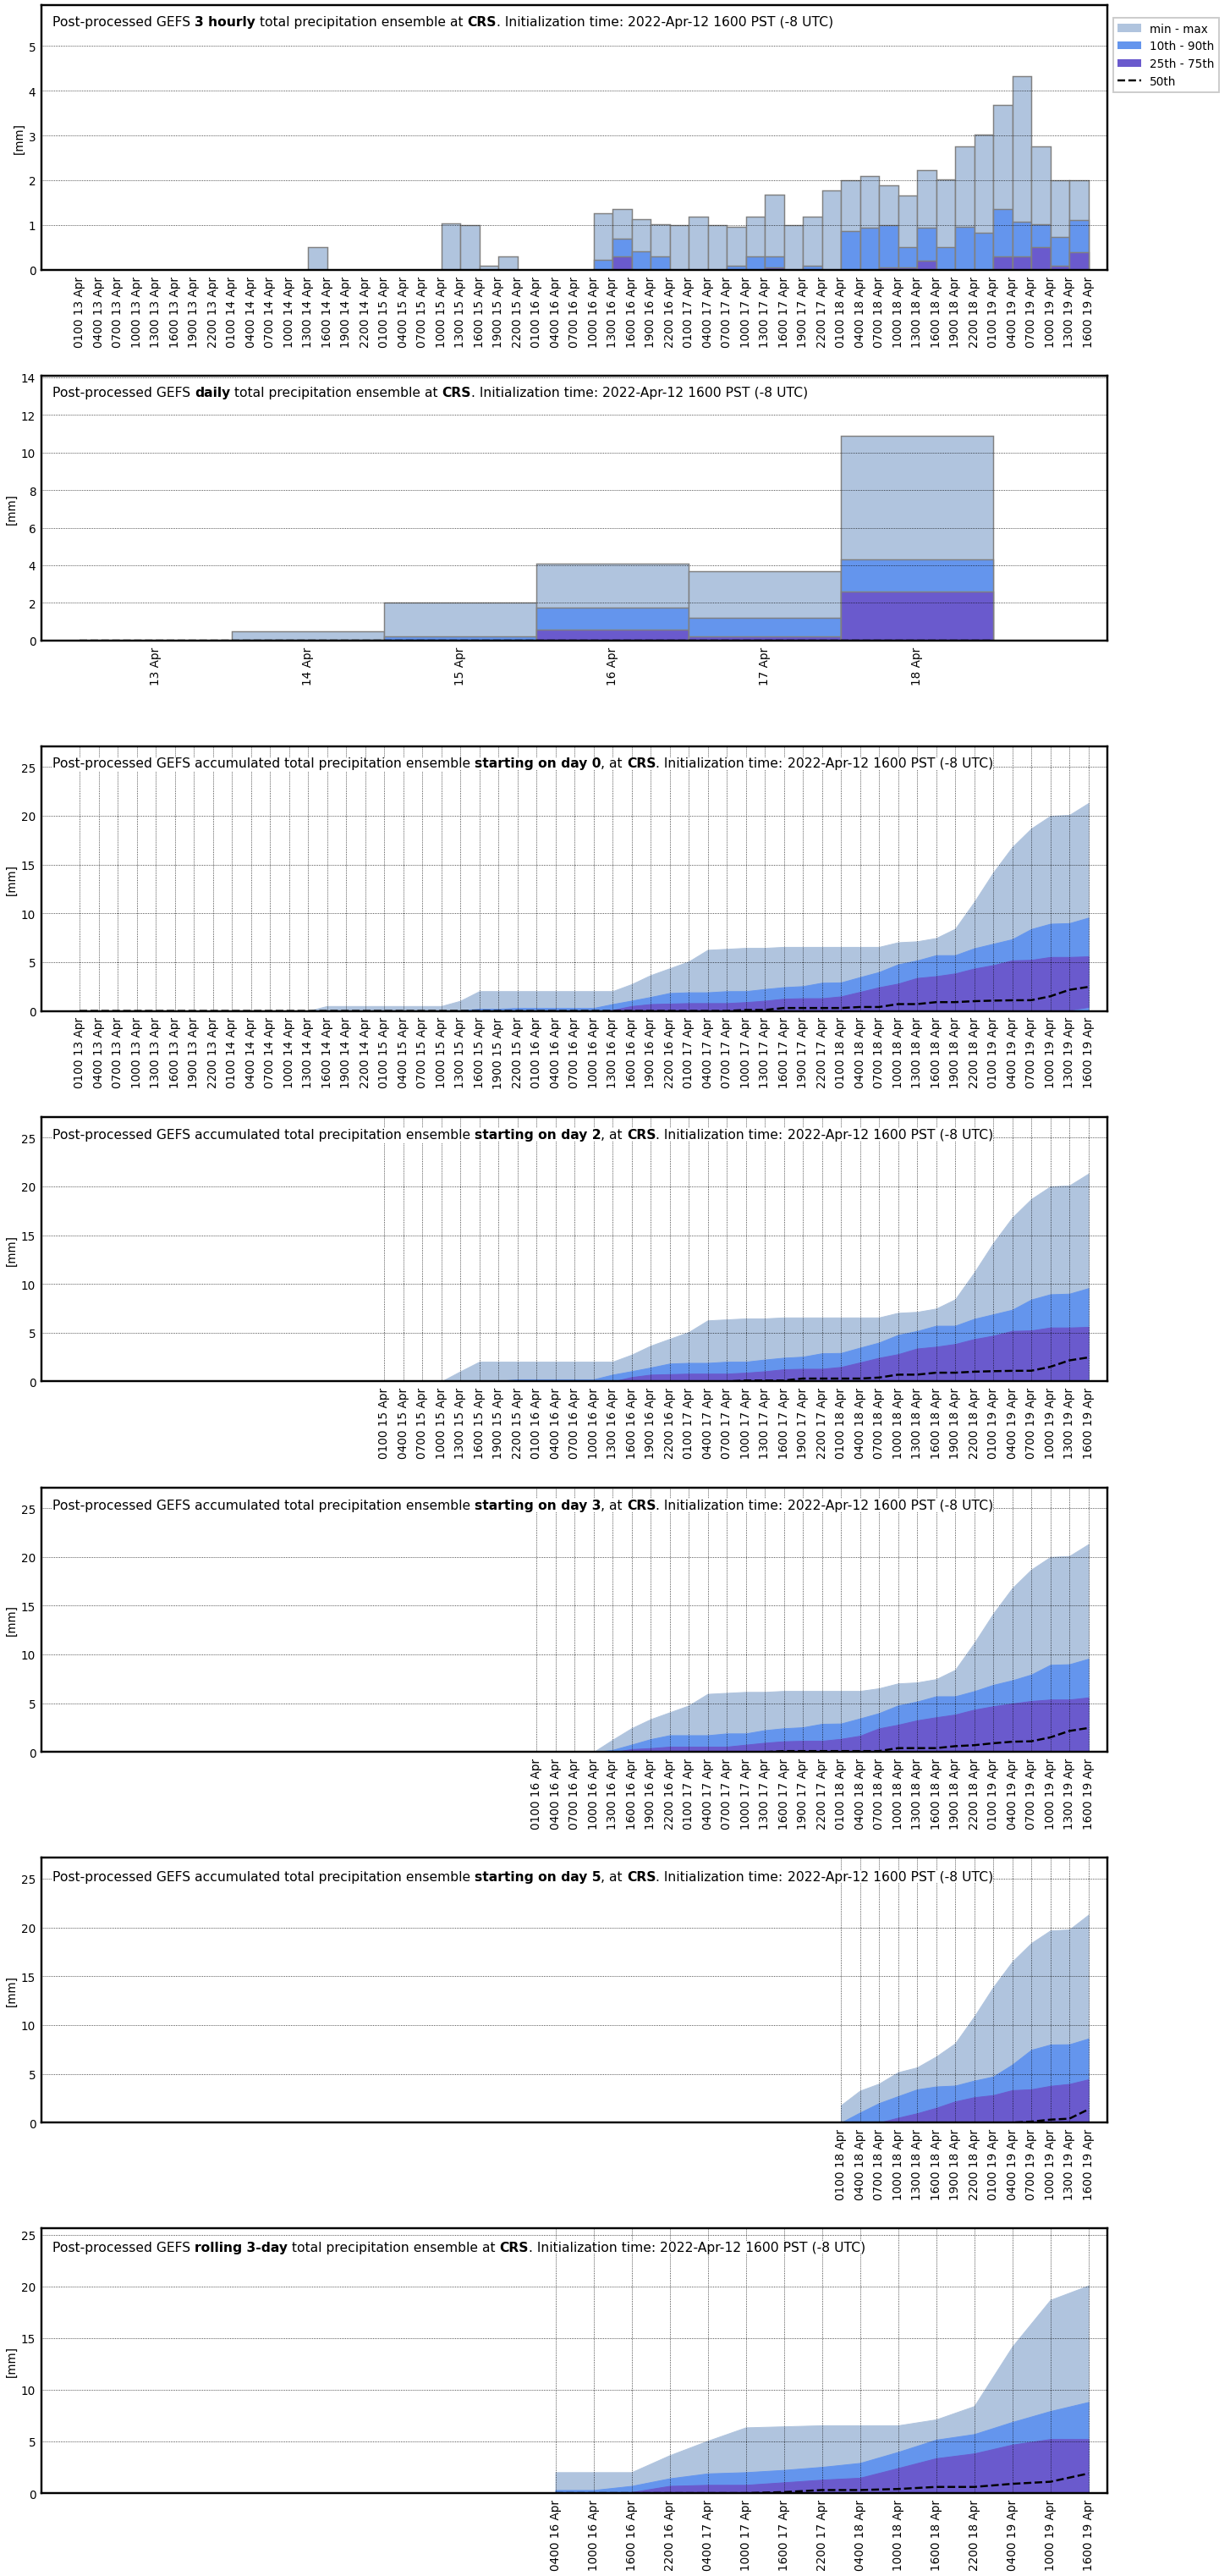

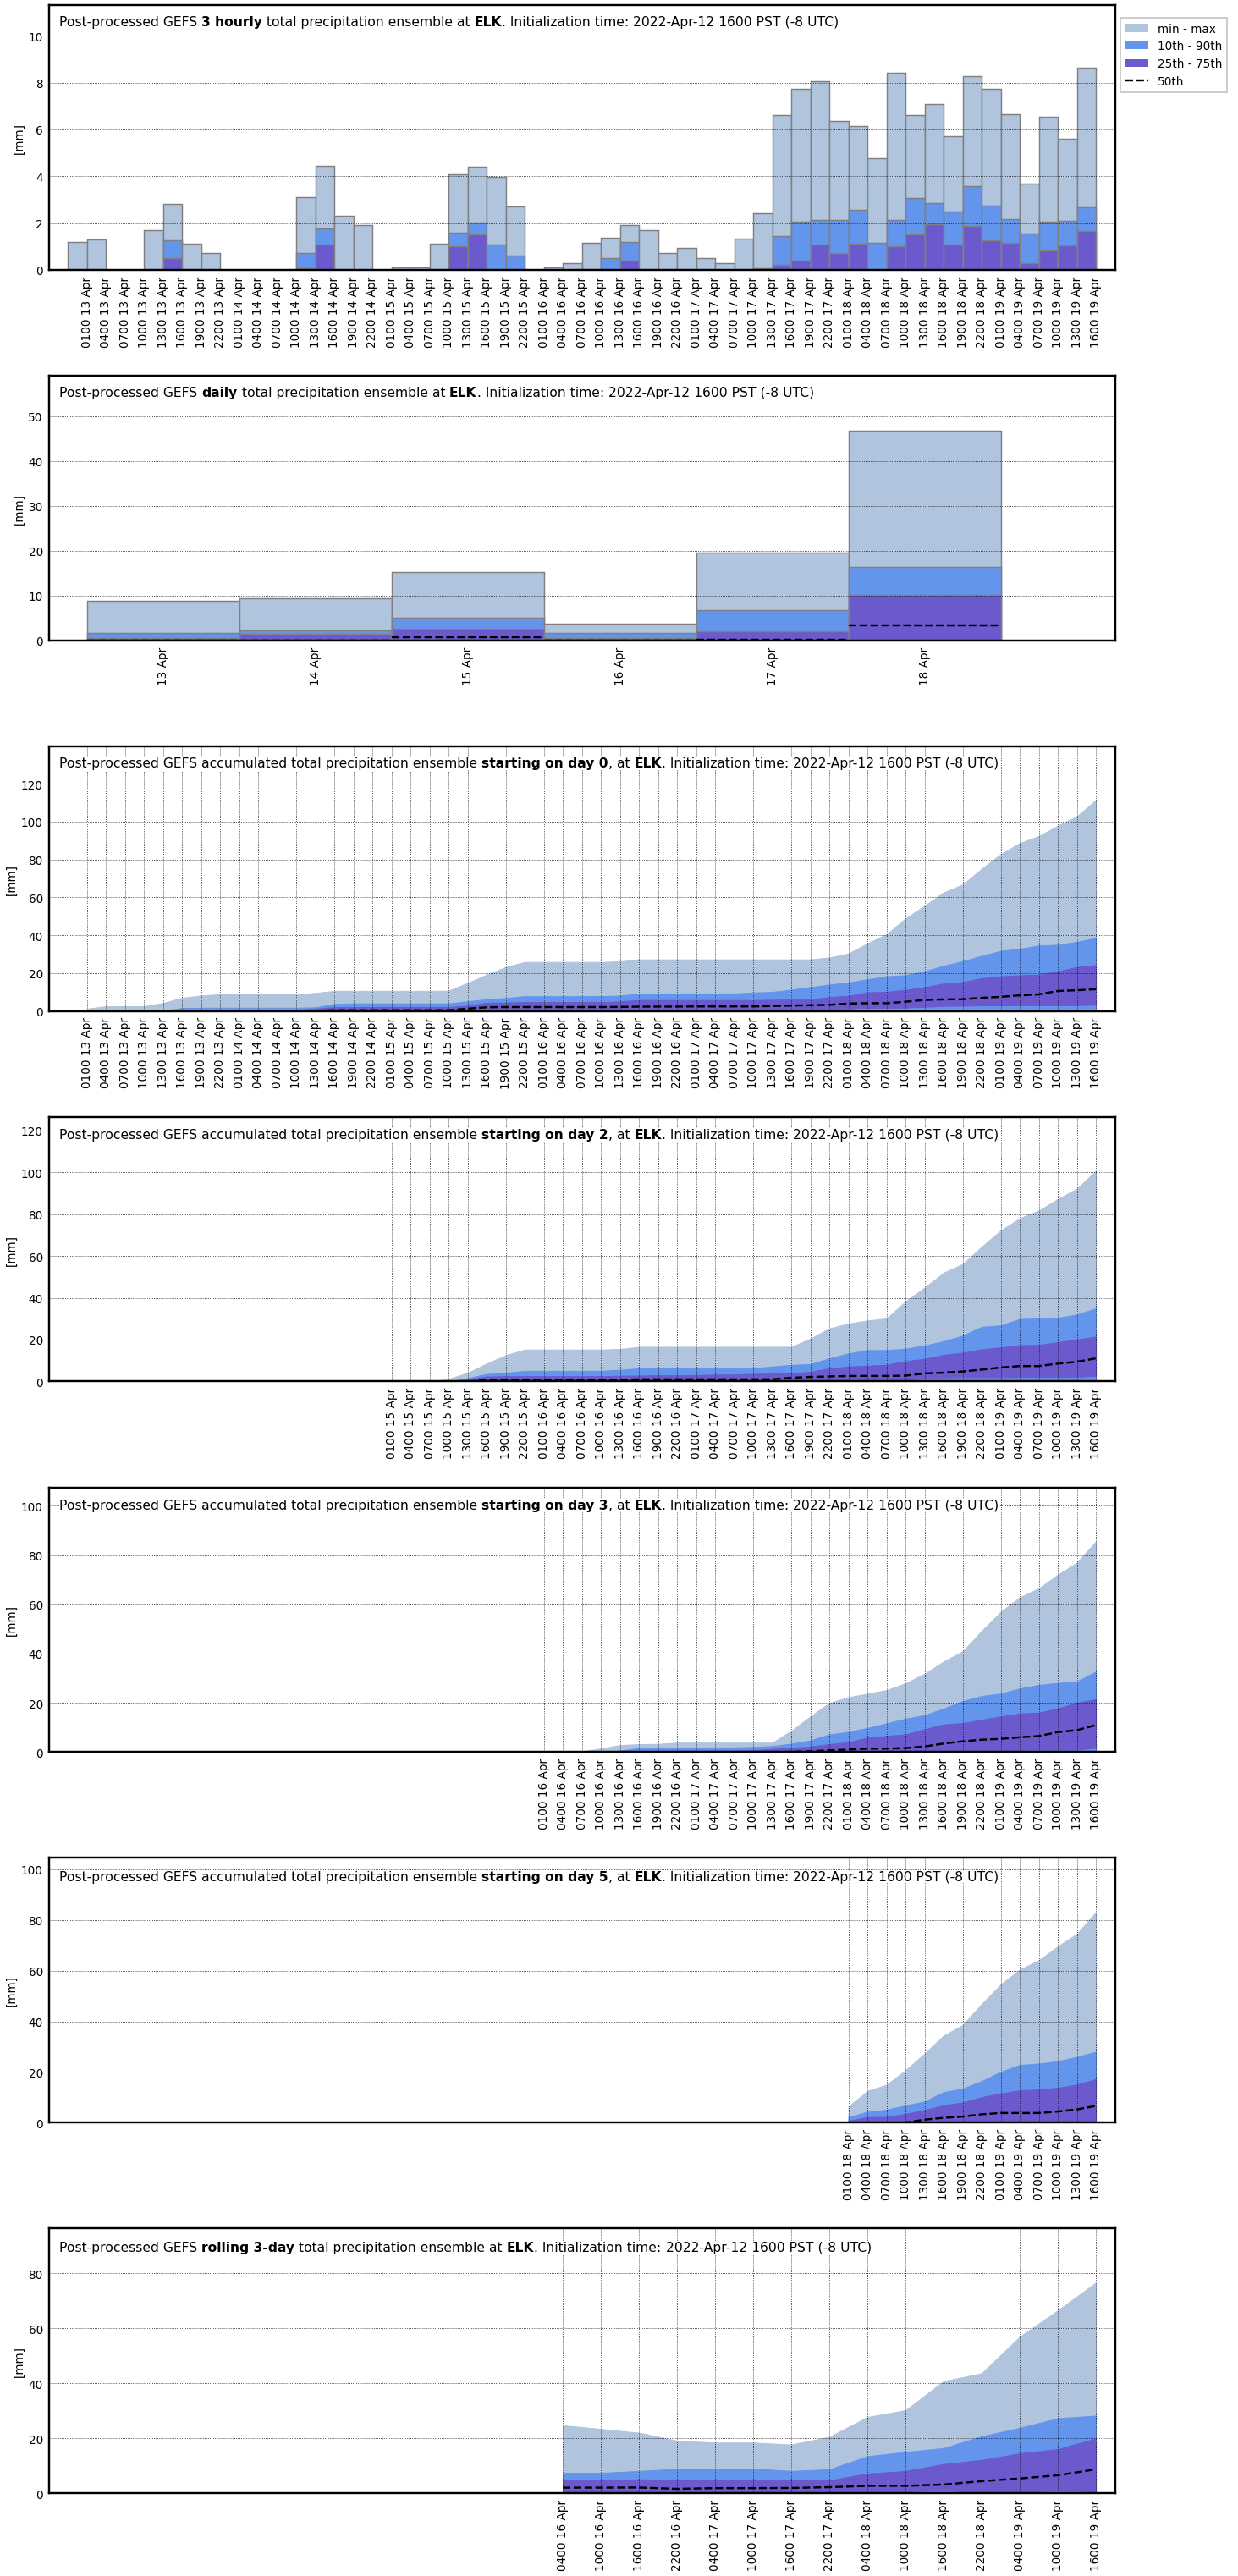

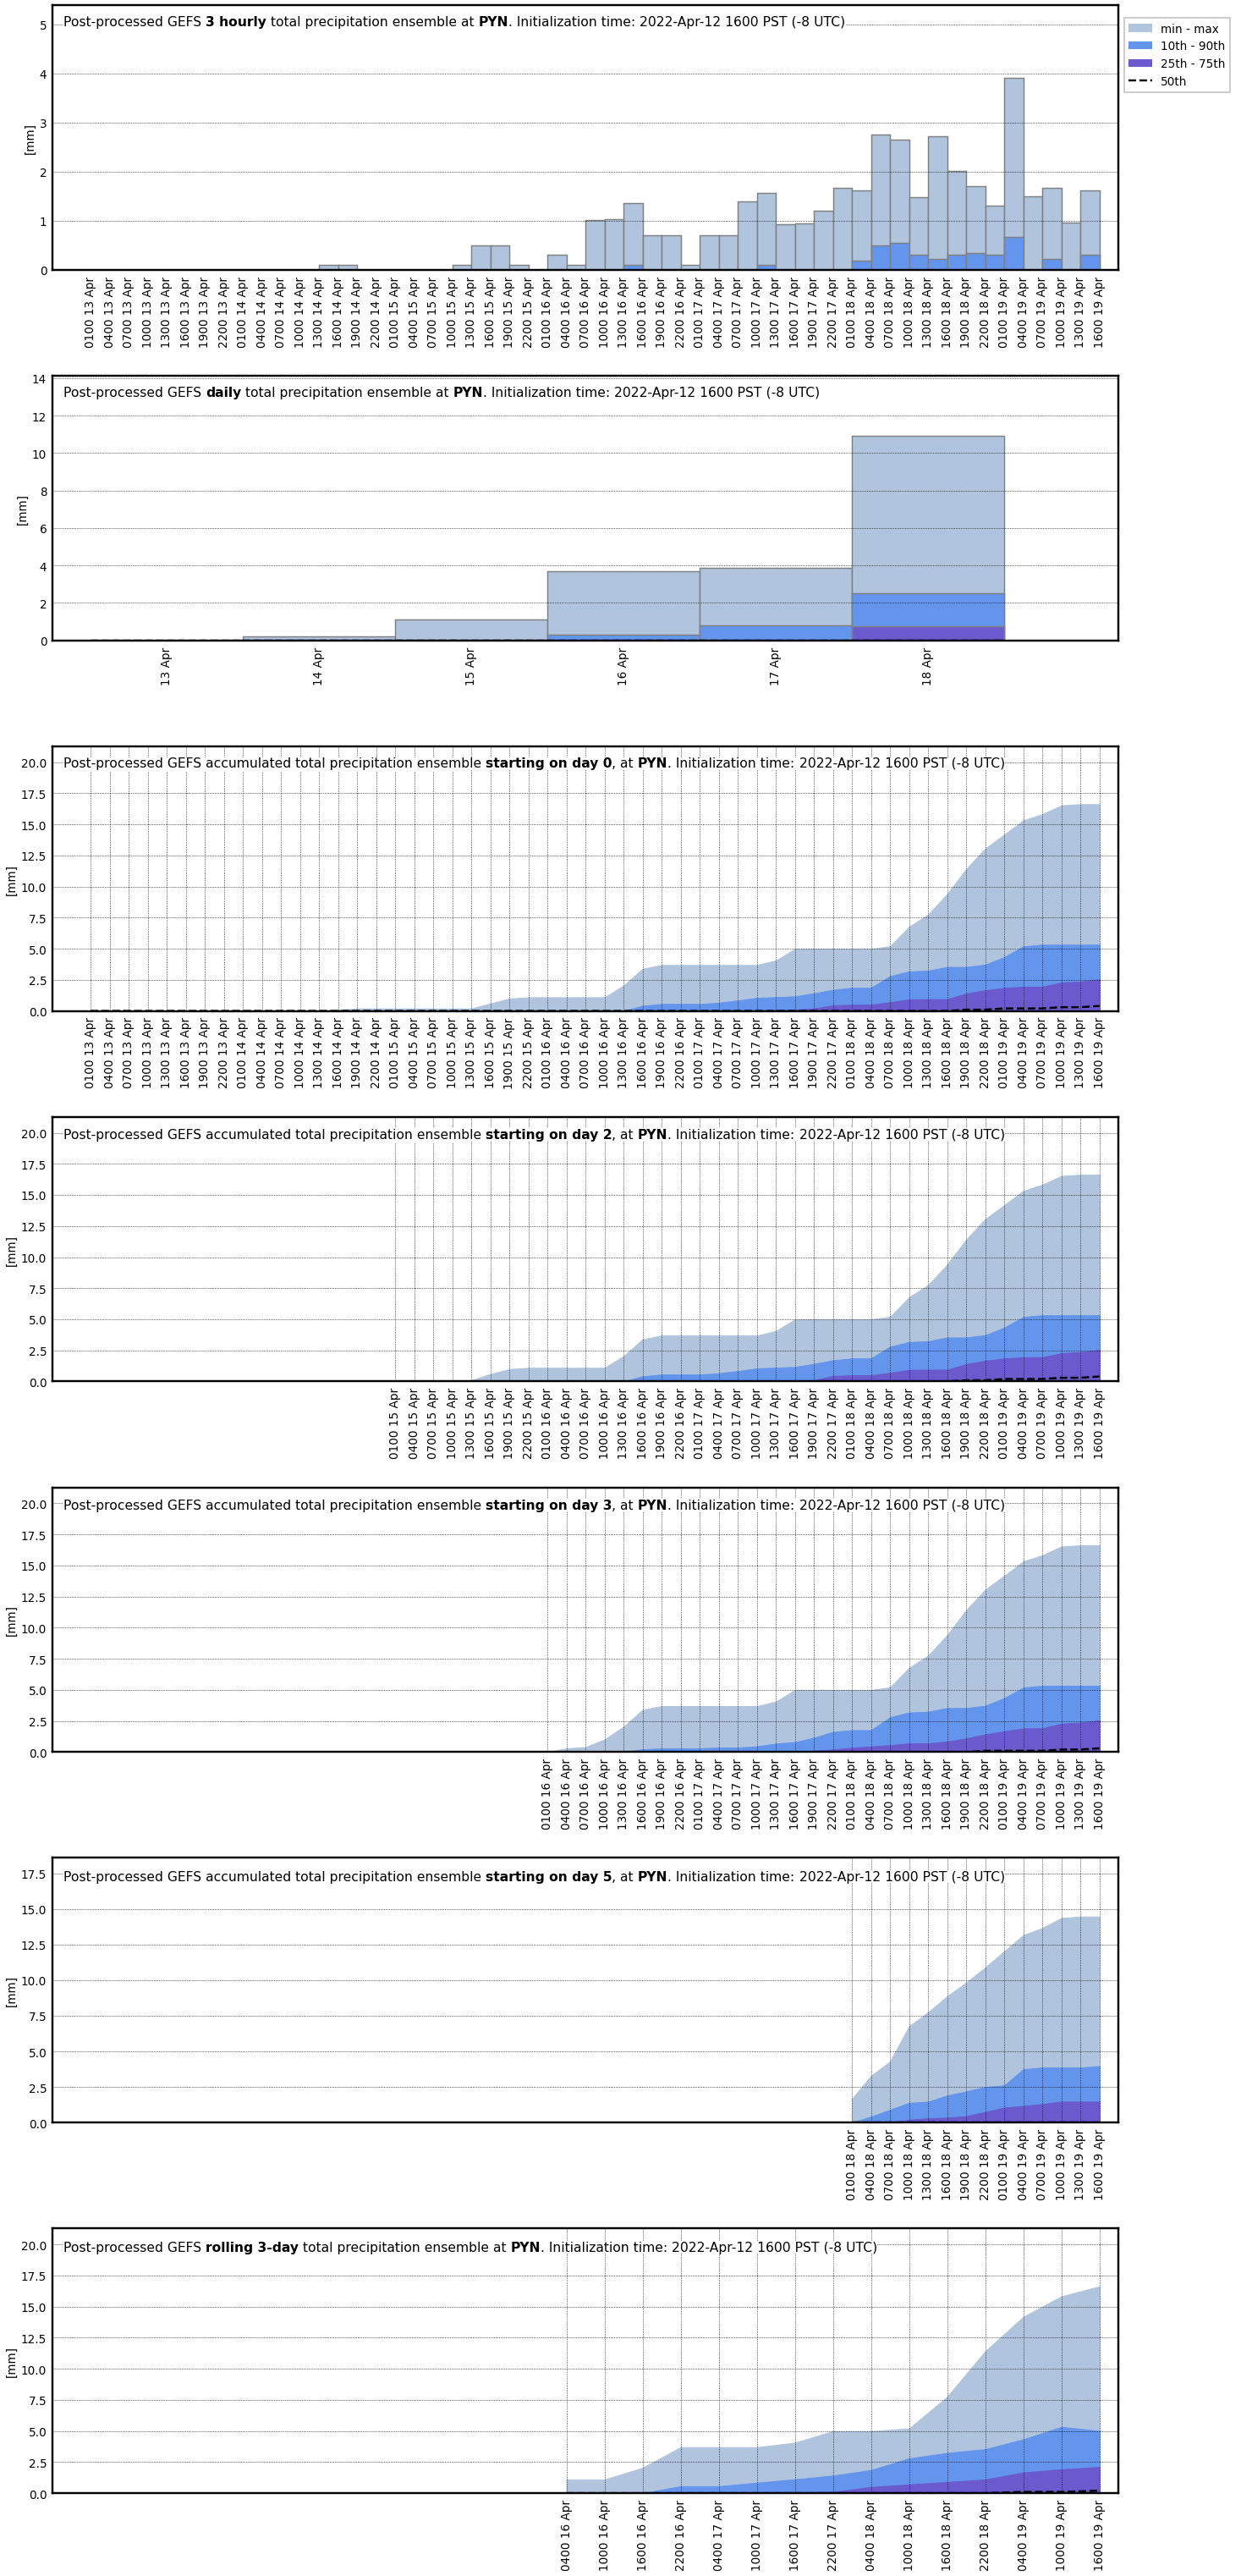

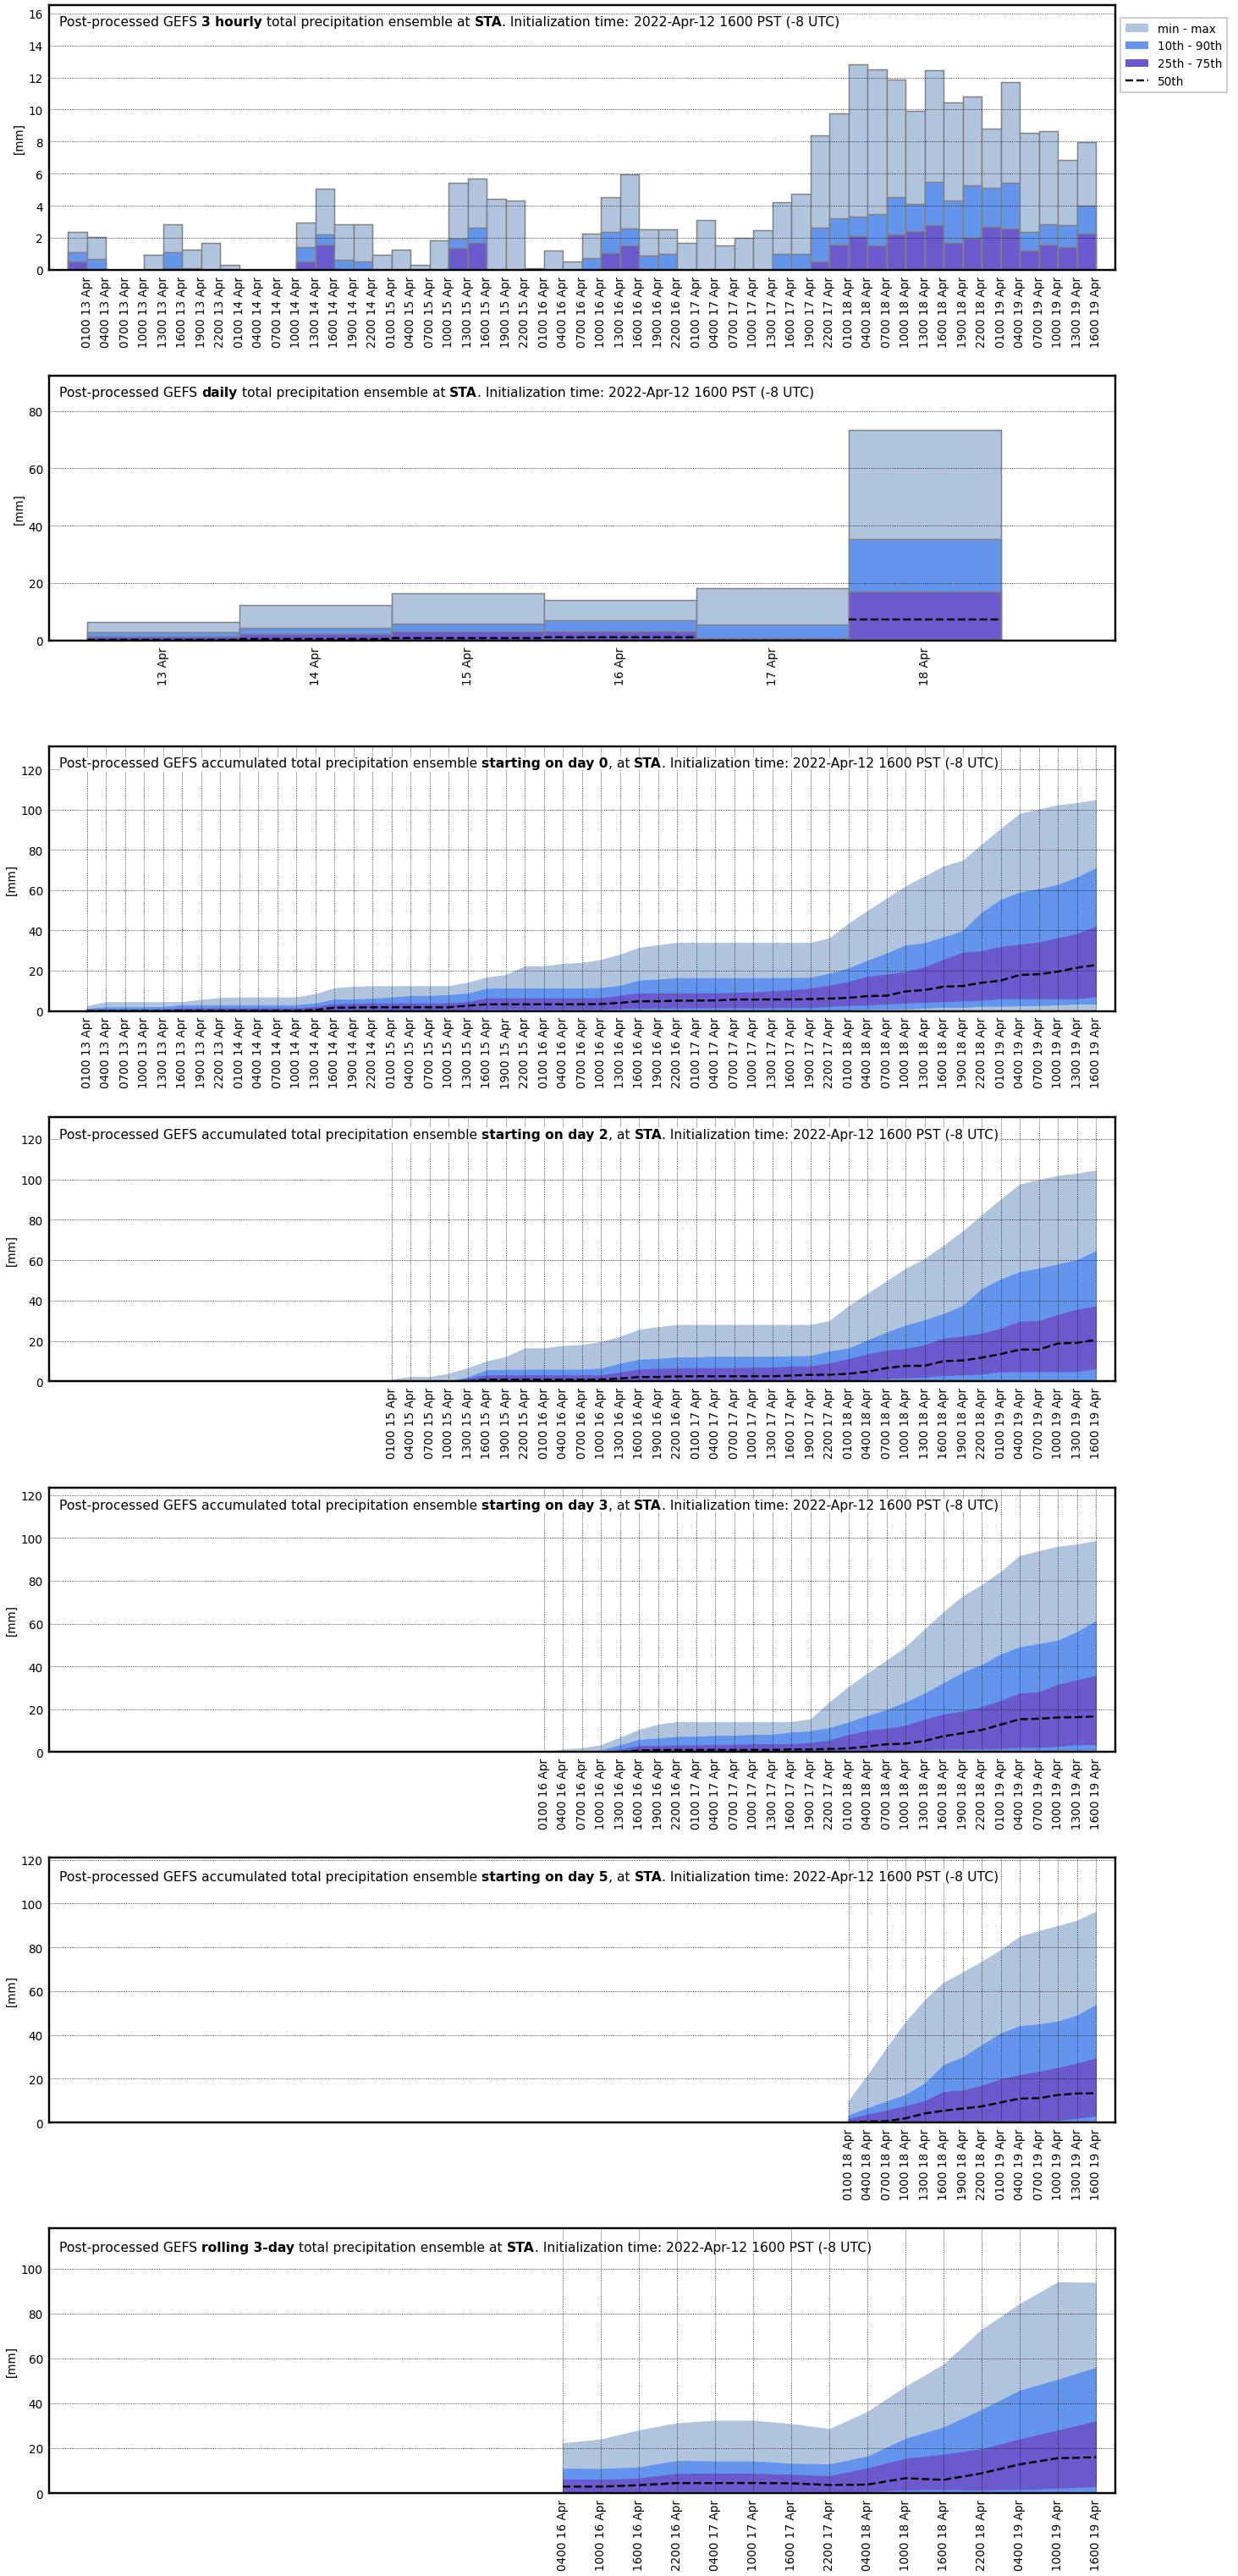

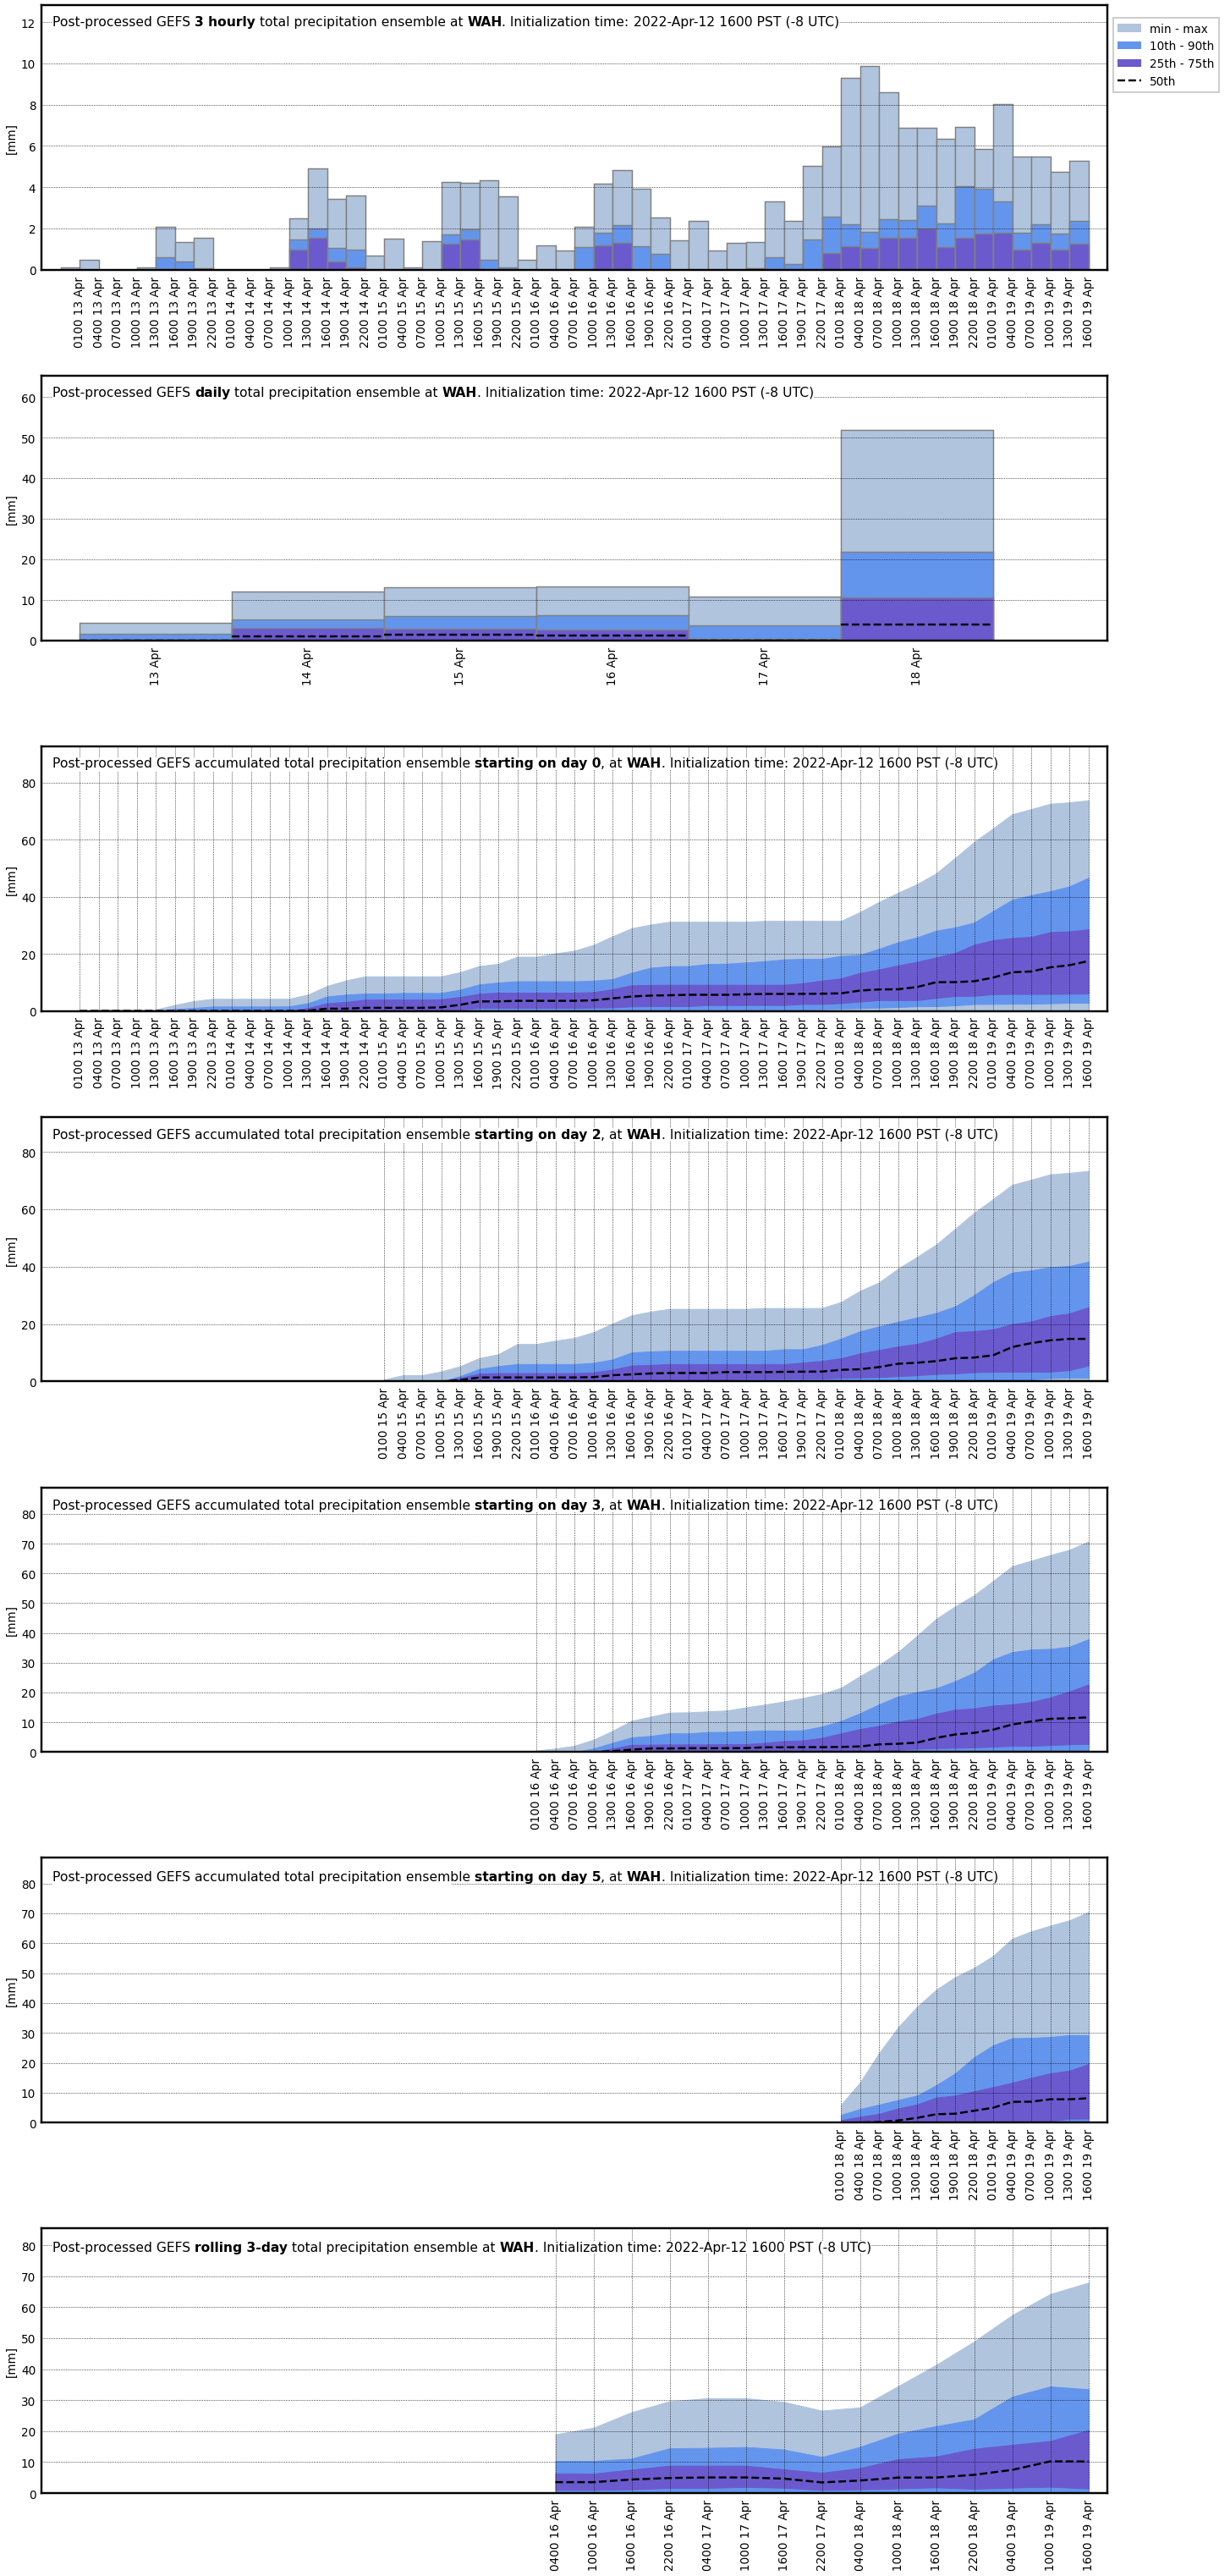

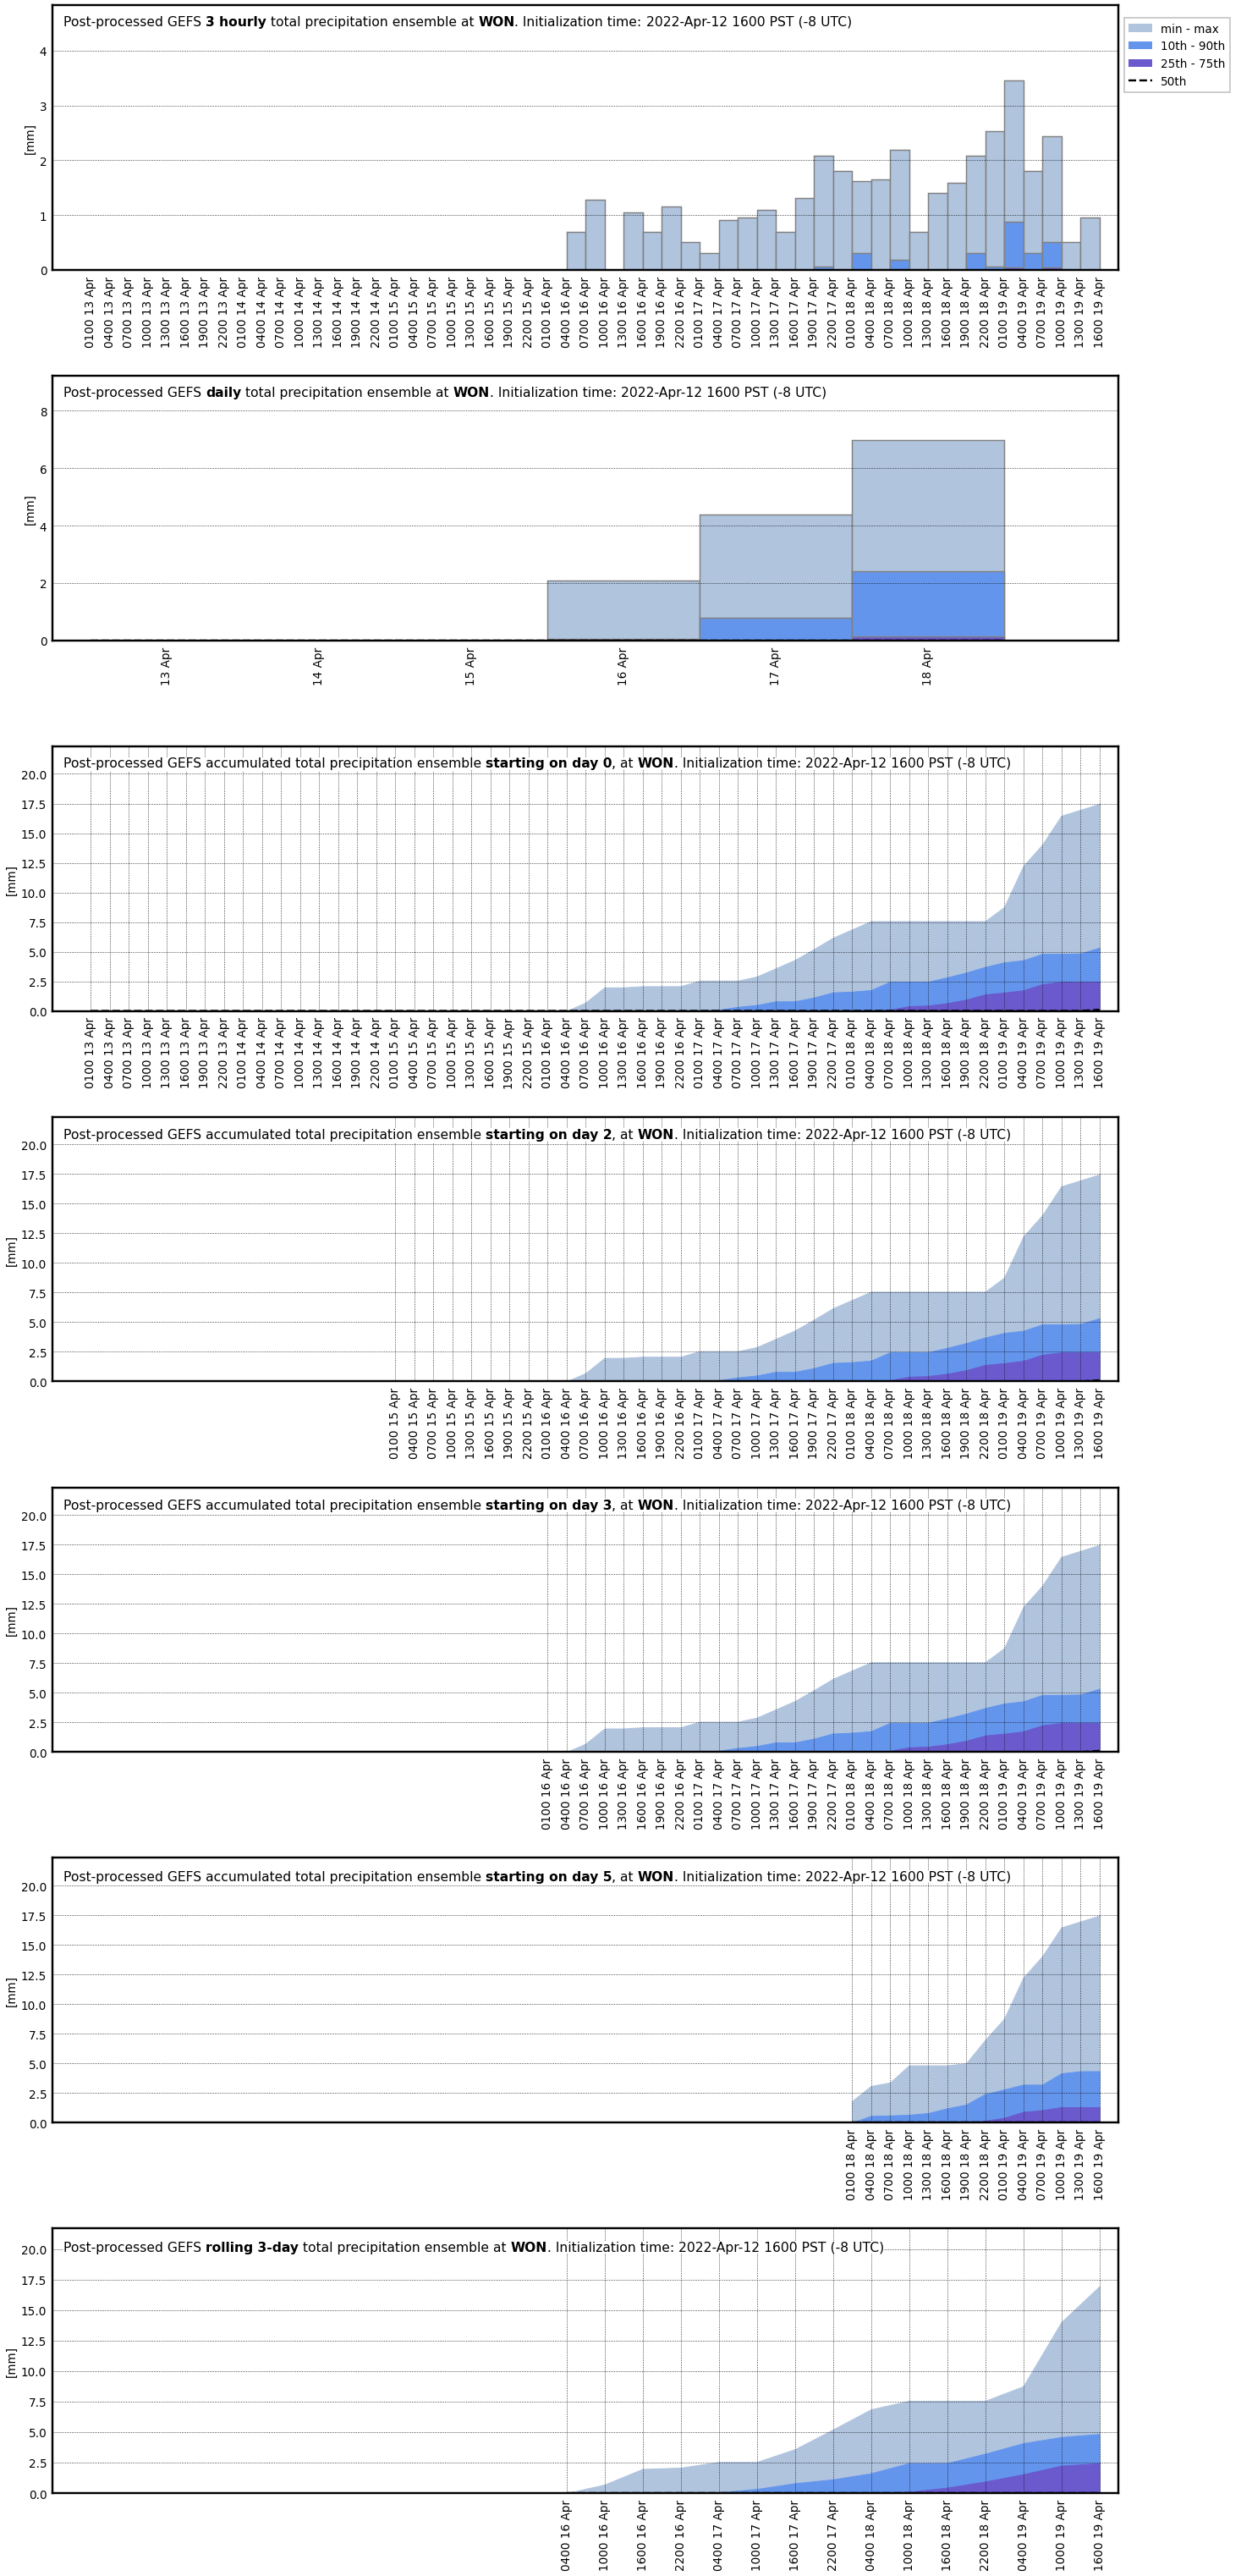

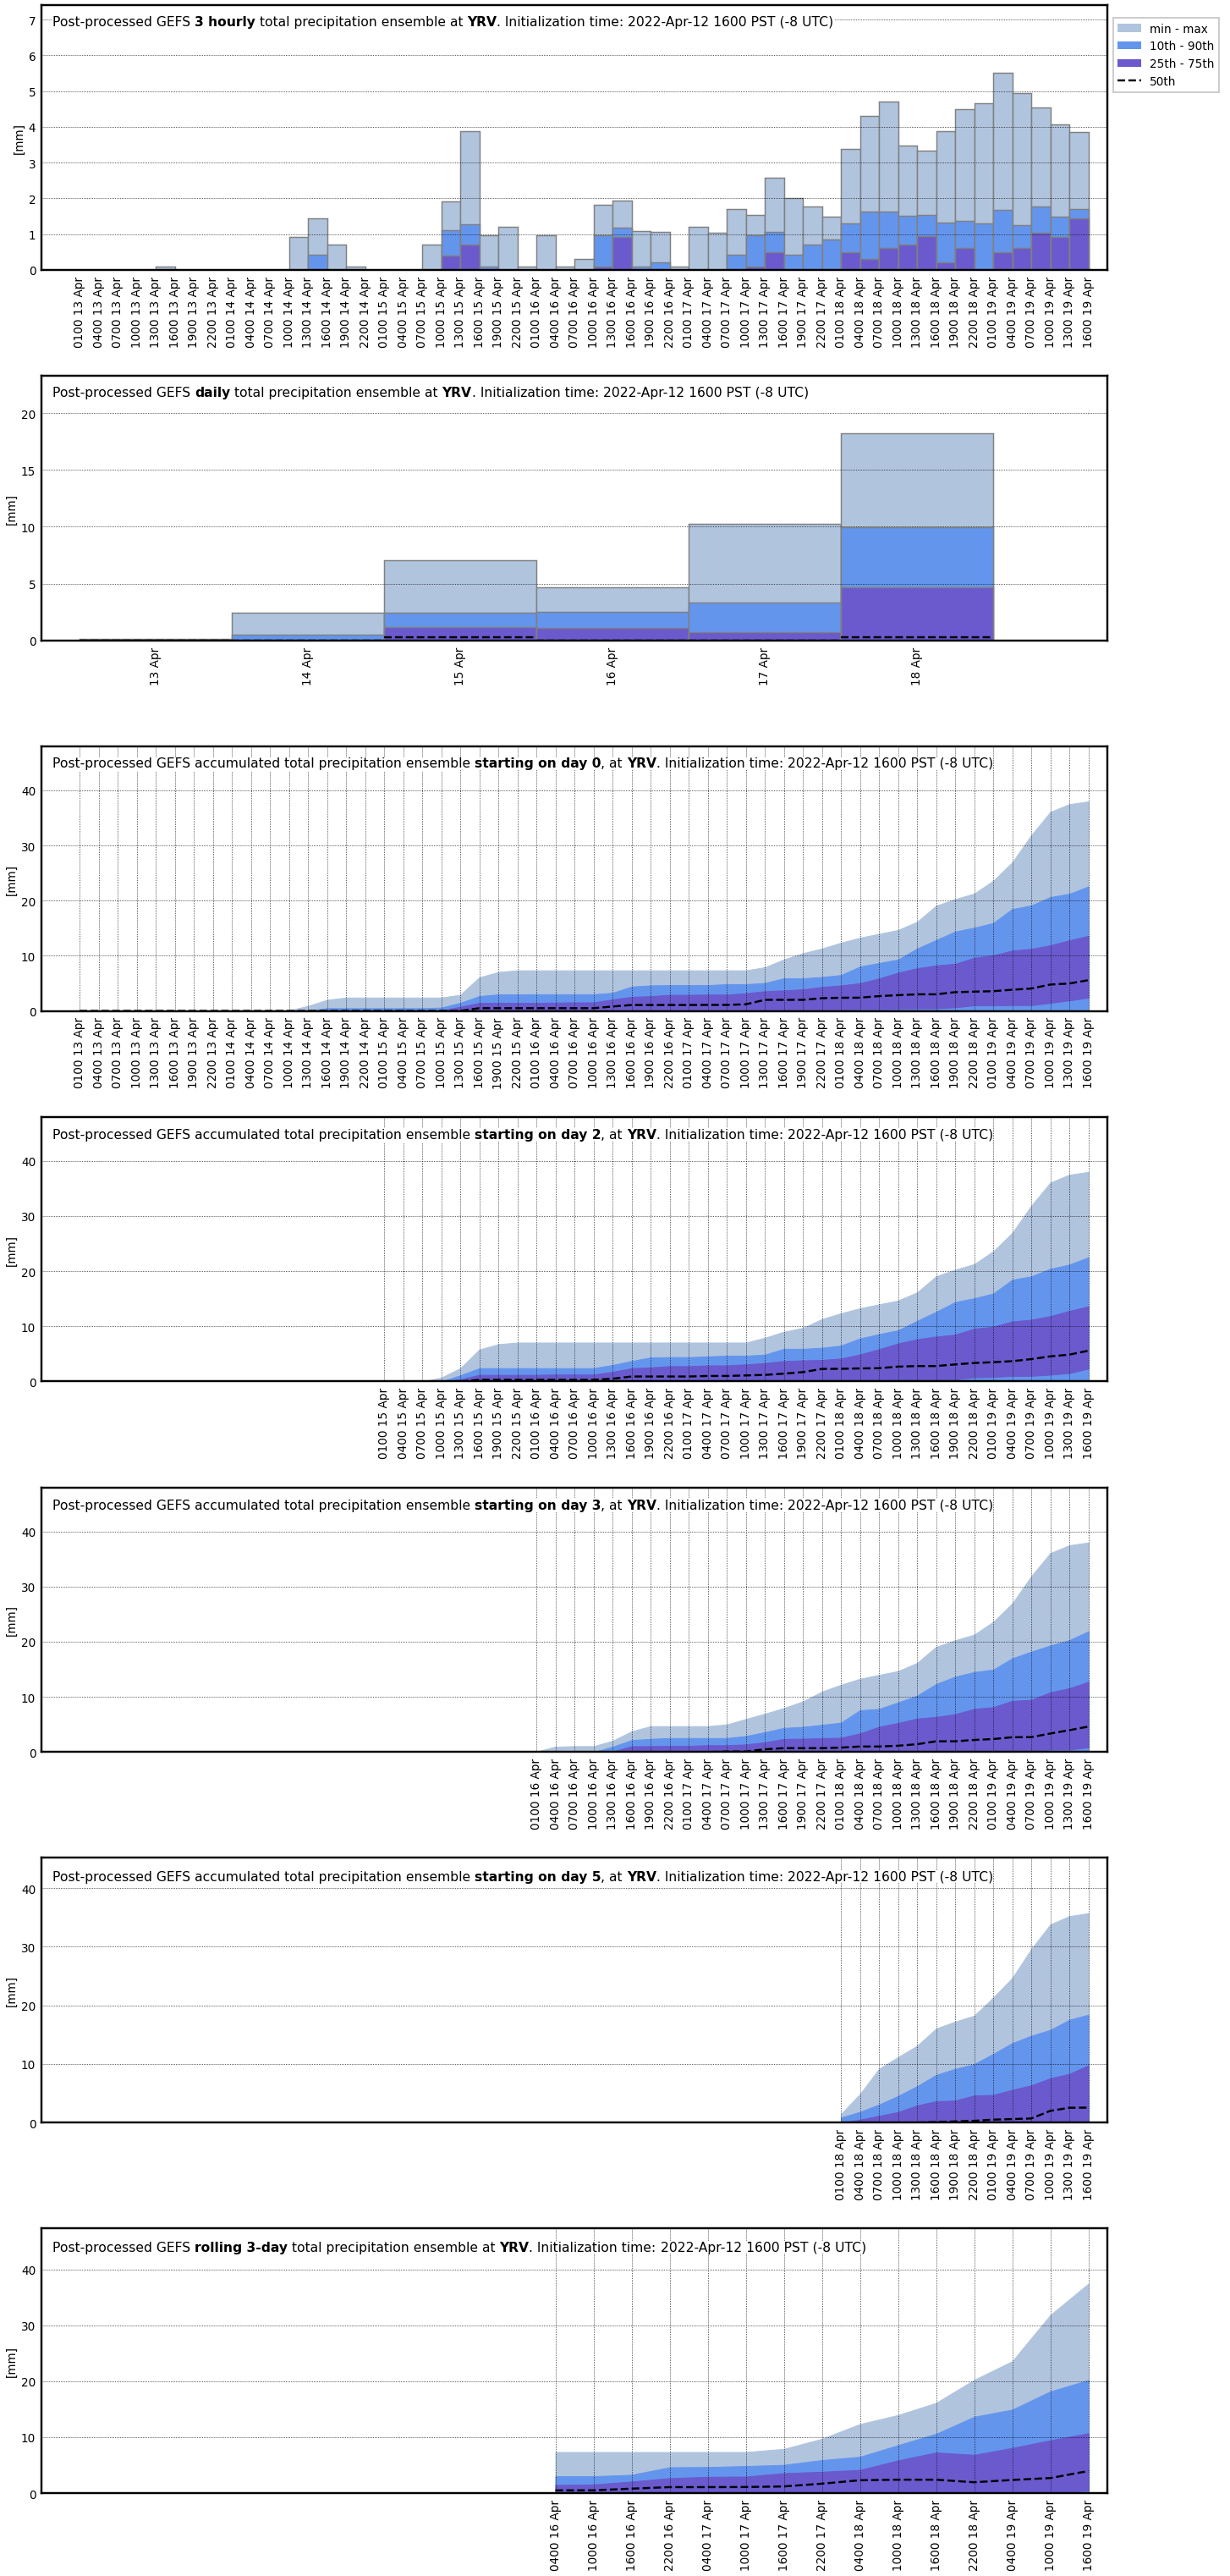

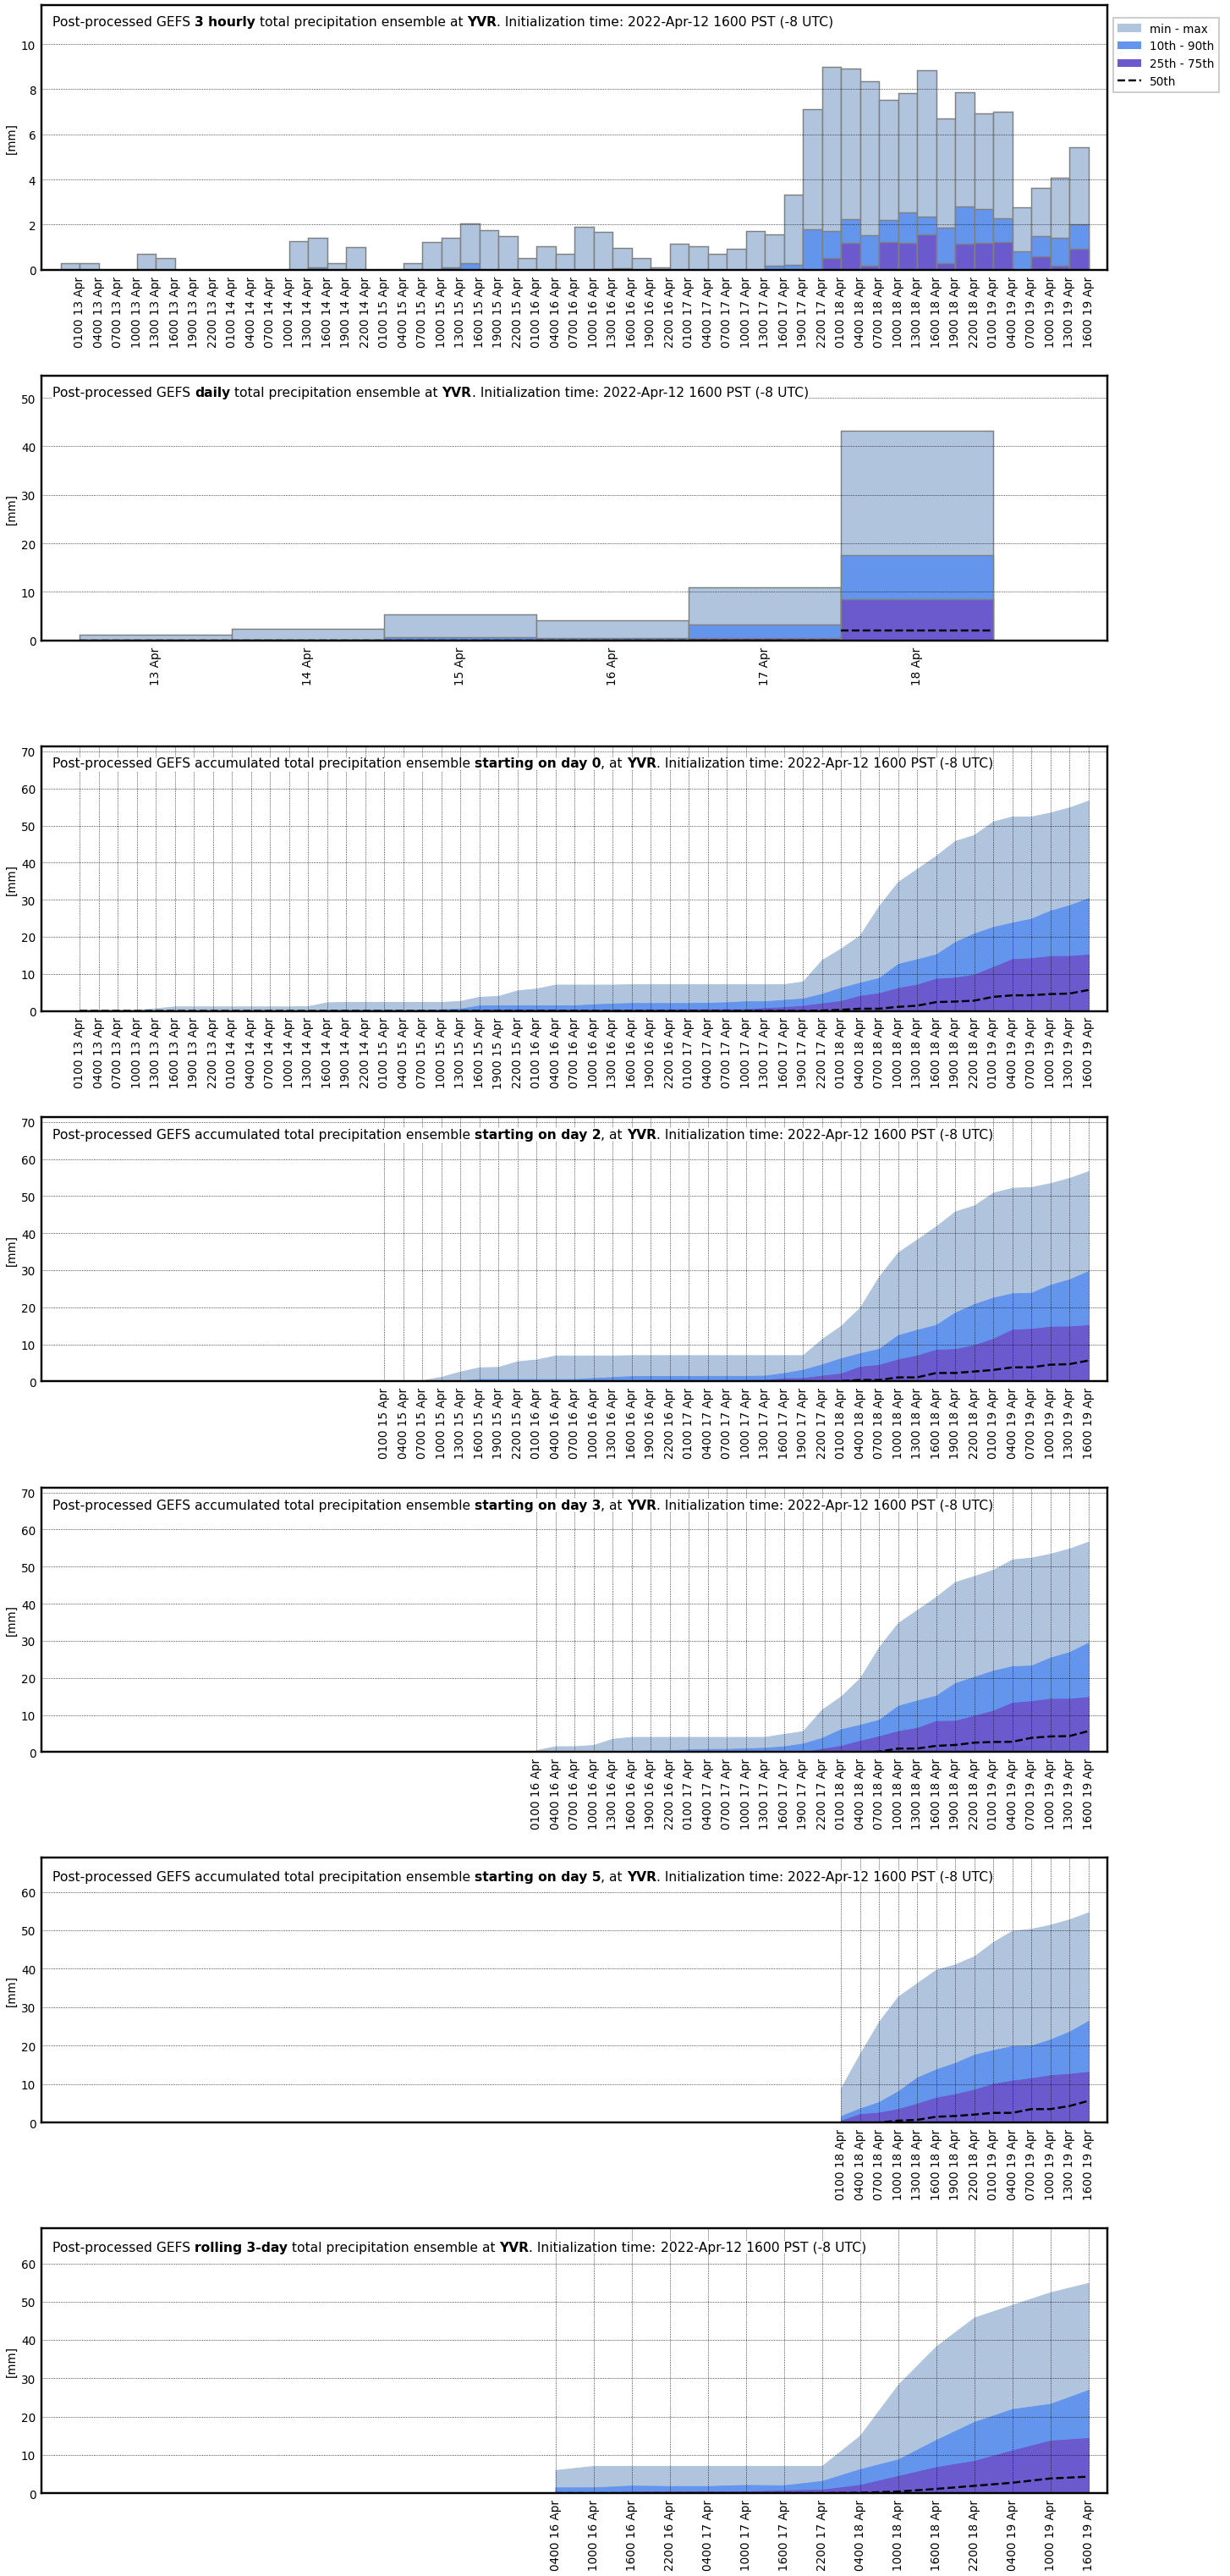

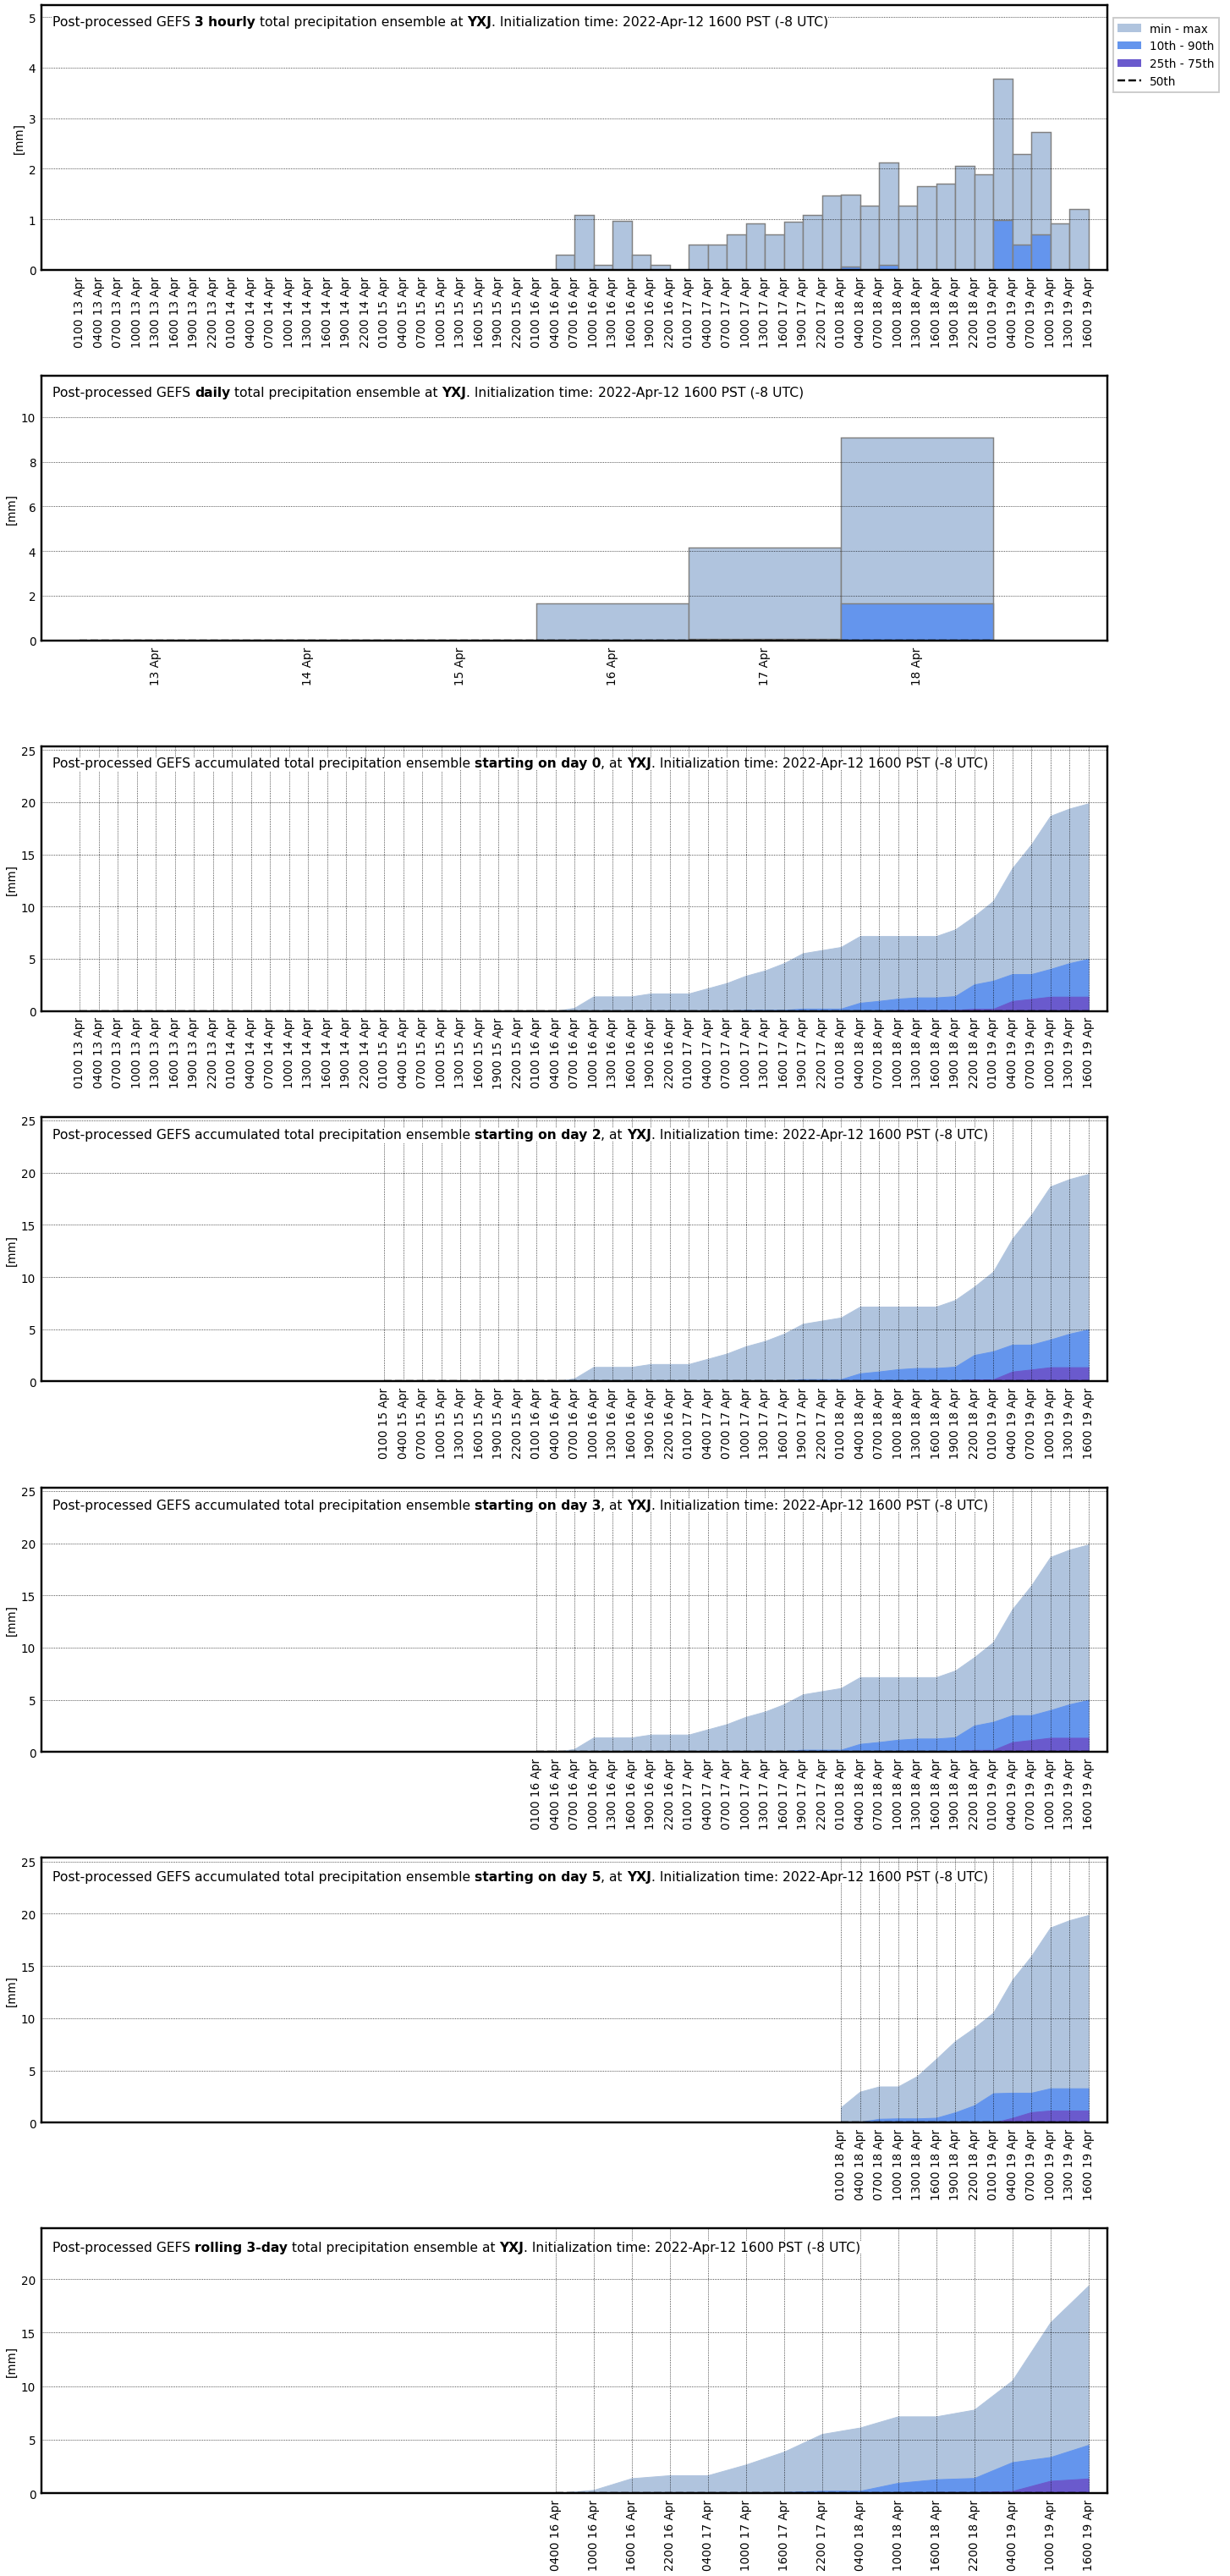

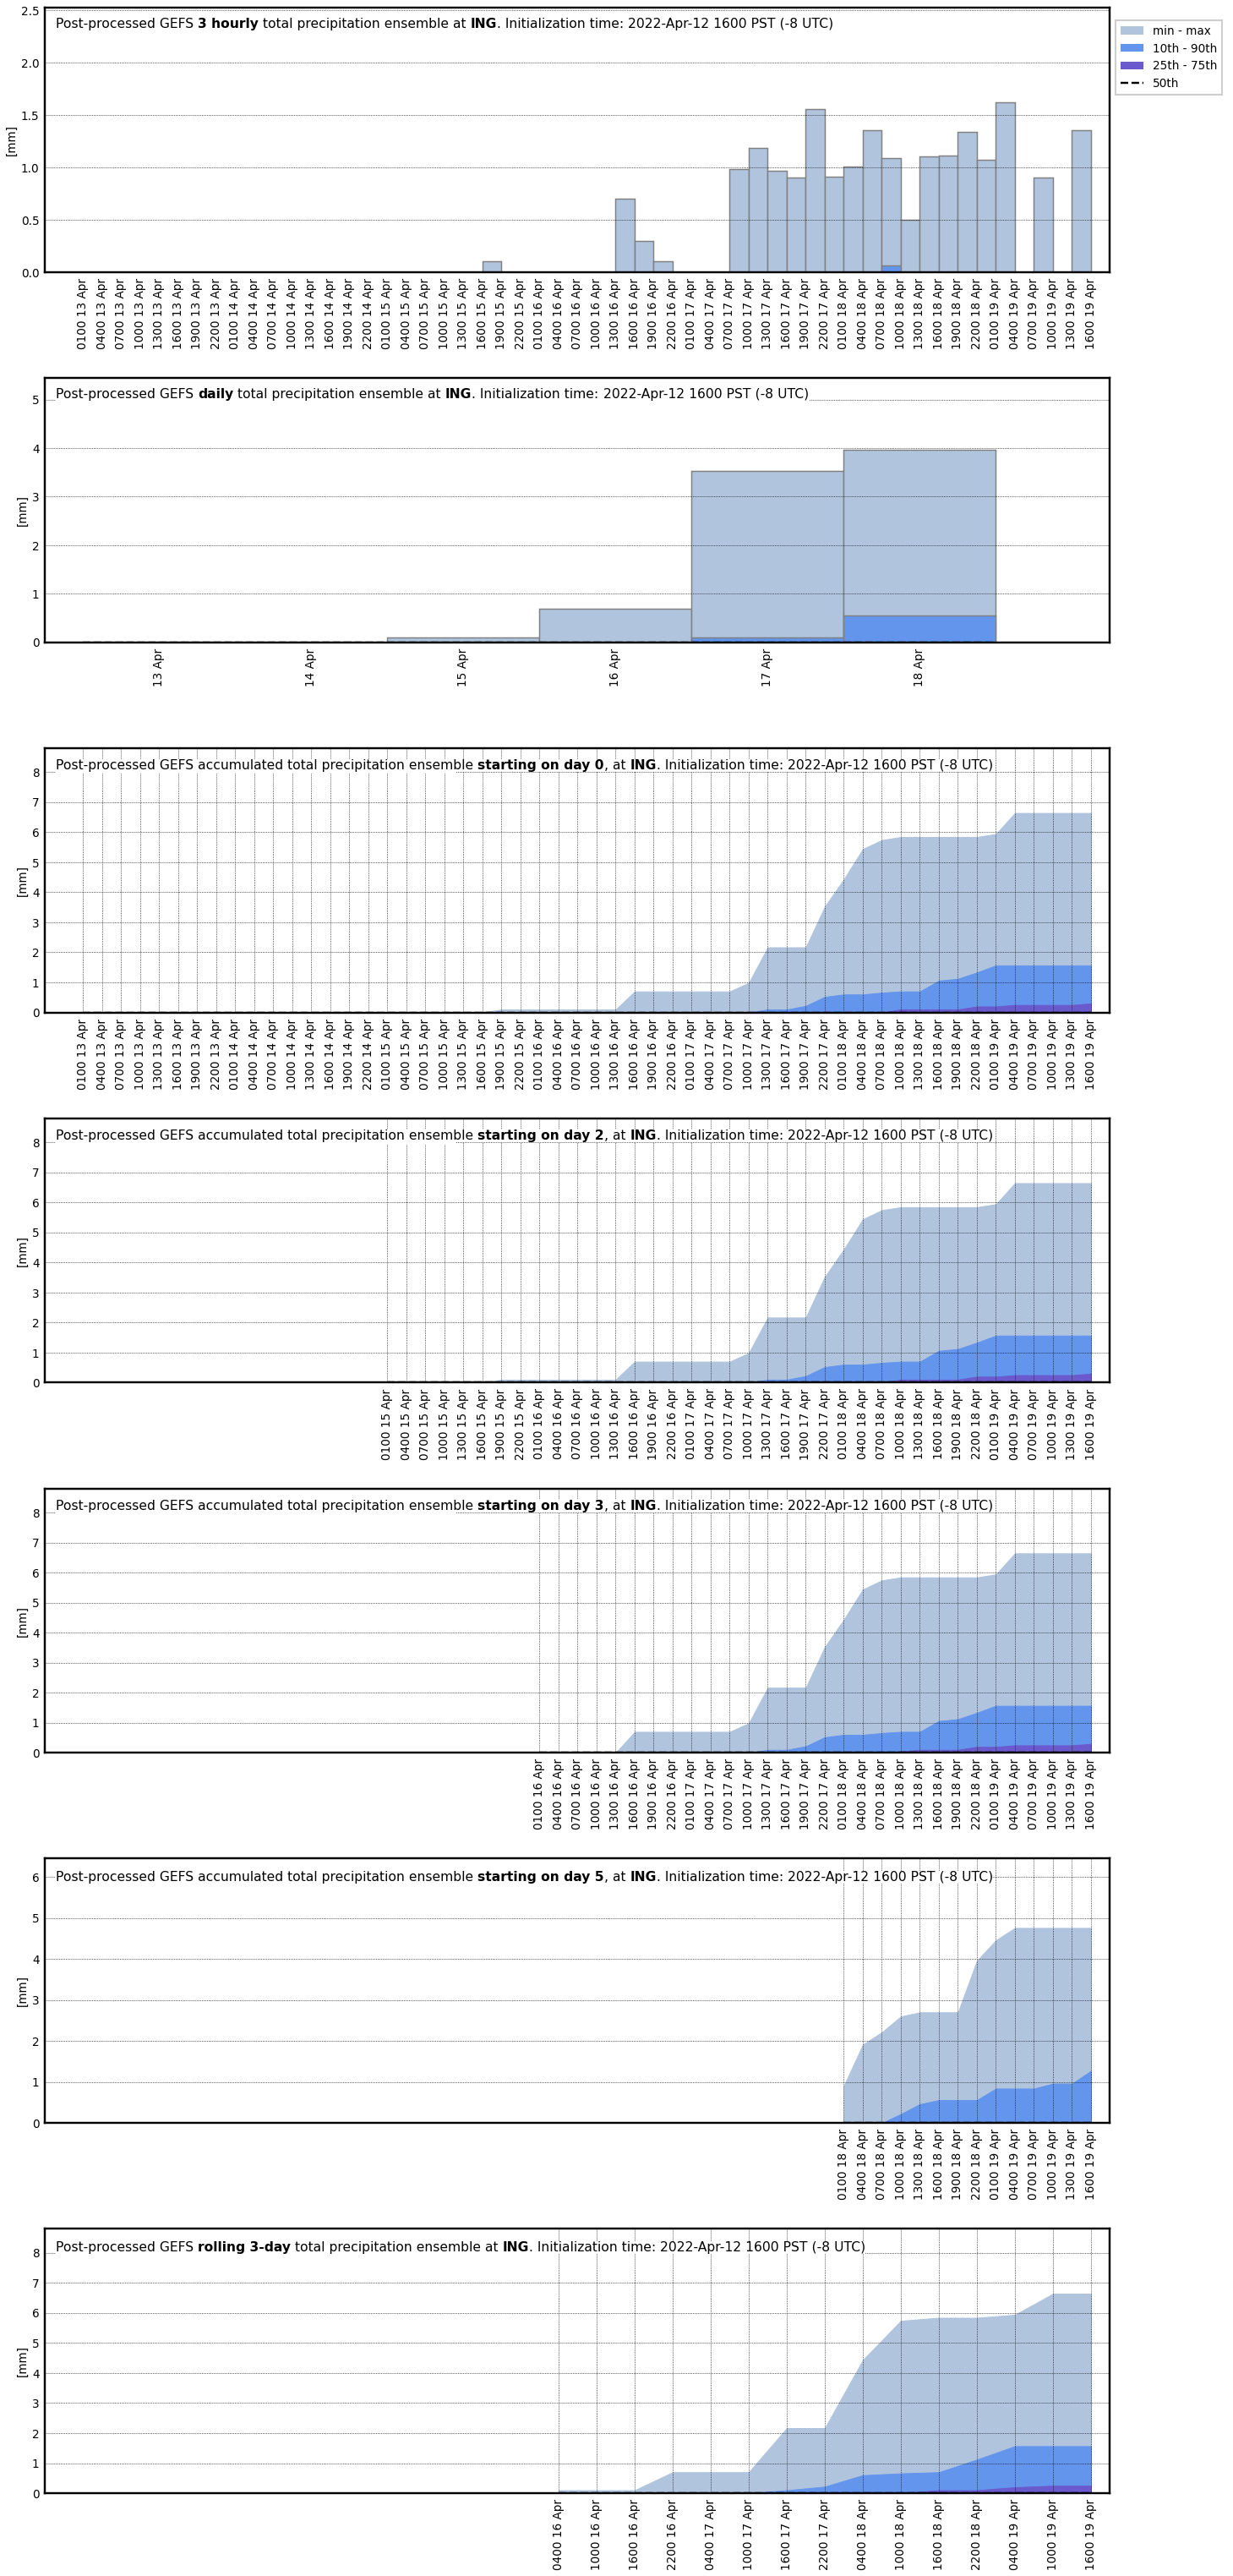

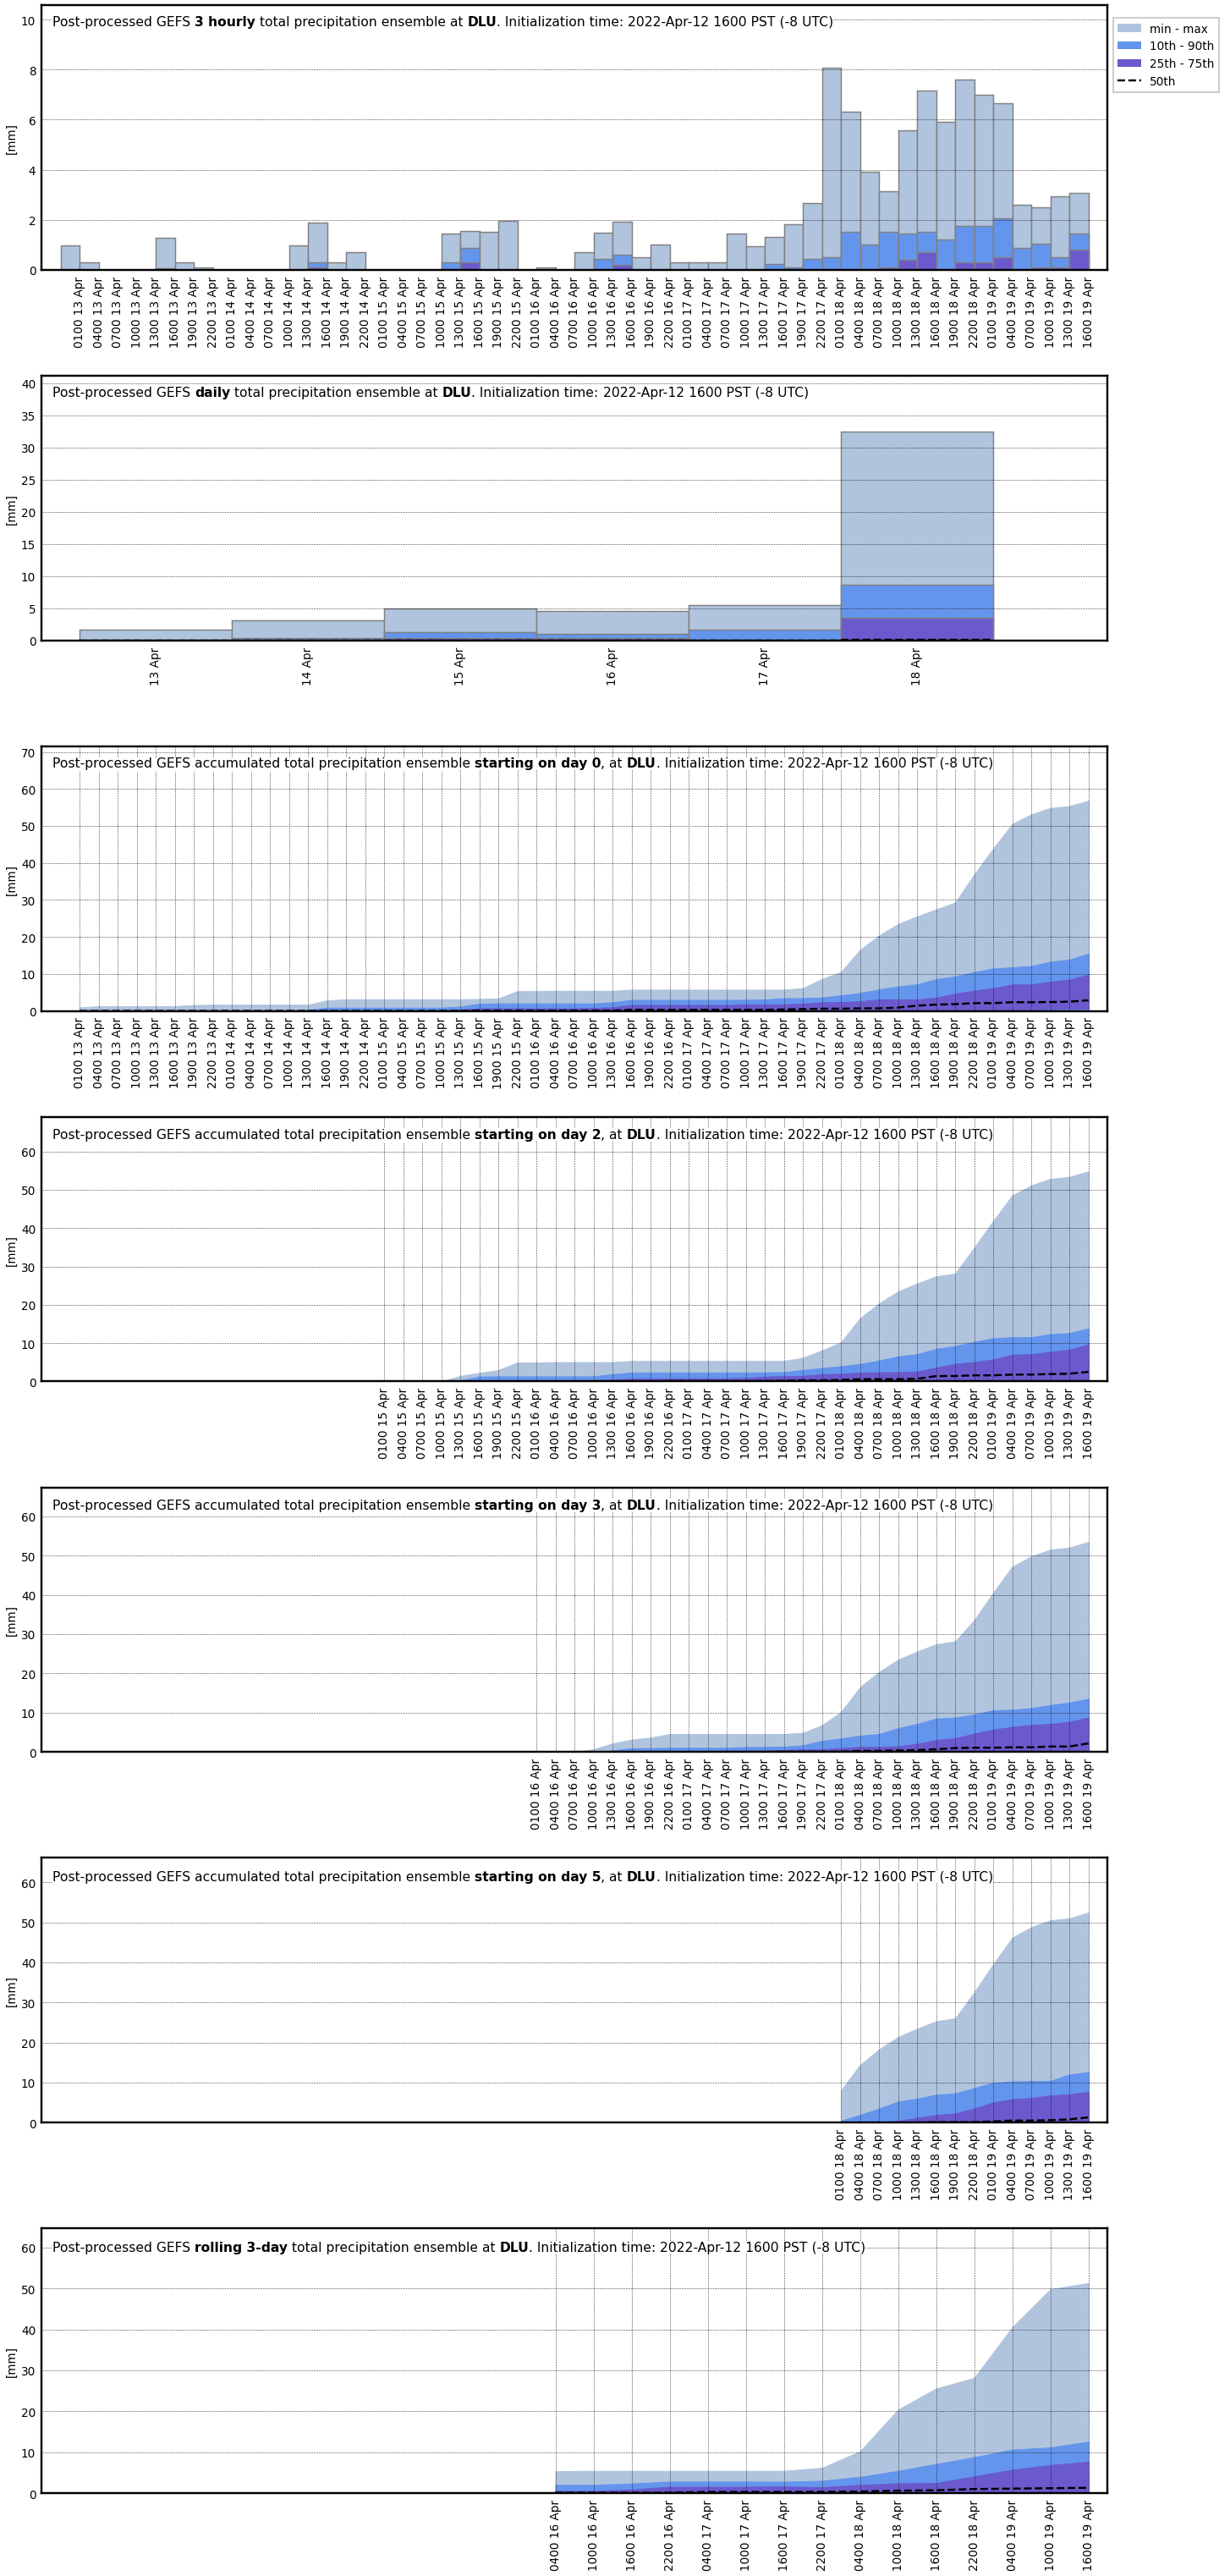

In [16]:
#L_stn
for n in range(L_stn):
    stn_name = stn_names[n]
    ix = indx[n]
    iy = indy[n]
    STN_CNN = CNN_output[:, :, ix, iy]
    
    DATA = {}
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_3_{}'.format(q_str)] = np.quantile(STN_CNN, q, axis=0)
        DATA['CNN_3_max'] =  np.nanmax(STN_CNN, axis=0)
        DATA['CNN_3_min'] =  np.nanmin(STN_CNN, axis=0)
    
    # -------------------- 24 h -------------------- #
    accum_window = 8 # 8x3h = 1 day
    output_freq = 8 # 2x3h = 6h per output
    skip_start = 0 # skip the first 3hr, start from 12hr instead of 9hr
    
    STN_CNN_24, inds_start, inds_end = utils.accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)
    
    LEADs_24H_hrs = LEADs_3H_hrs[inds_end]
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_24_{}'.format(q_str)] = np.quantile(STN_CNN_24, q, axis=0)
        DATA['CNN_24_max'] =  np.nanmax(STN_CNN_24, axis=0)
        DATA['CNN_24_min'] =  np.nanmin(STN_CNN_24, axis=0)
        
    # -------------------- 72 h -------------------- #
    accum_window = 24 # 24x3h = 3 day
    output_freq = 2 # 2x3h = 6h per output
    skip_start = 1 # skip the first 3hr, start from 12hr instead of 9hr 

    STN_CNN_72, inds_start, inds_end = utils.accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)
    
    LEADs_72H_hrs = LEADs_3H_hrs[inds_end]
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_72_{}'.format(q_str)] = np.quantile(STN_CNN_72, q, axis=0)
        DATA['CNN_72_max'] =  np.nanmax(STN_CNN_72, axis=0)
        DATA['CNN_72_min'] =  np.nanmin(STN_CNN_72, axis=0)
    
    
    STN_CNN_accum = np.cumsum(STN_CNN, axis=1)
    LEADS_accum_d0 = np.copy(LEADs_3H_hrs)
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_d0_{}'.format(q_str)] = np.quantile(STN_CNN_accum, q, axis=0)        
        DATA['CNN_d0_max'] =  np.nanmax(STN_CNN_accum, axis=0)
        DATA['CNN_d0_min'] =  np.nanmin(STN_CNN_accum, axis=0)
        
    
    STN_CNN_accum = np.cumsum(STN_CNN[:, 16:], axis=1)
    LEADS_accum_d2 = np.copy(LEADs_3H_hrs[16:])
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_d2_{}'.format(q_str)] = np.quantile(STN_CNN_accum, q, axis=0)        
        DATA['CNN_d2_max'] =  np.nanmax(STN_CNN_accum, axis=0)
        DATA['CNN_d2_min'] =  np.nanmin(STN_CNN_accum, axis=0)
       
    
    STN_CNN_accum = np.cumsum(STN_CNN[:, 24:], axis=1)
    LEADS_accum_d3 = np.copy(LEADs_3H_hrs[24:])
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_d3_{}'.format(q_str)] = np.quantile(STN_CNN_accum, q, axis=0)        
        DATA['CNN_d3_max'] =  np.nanmax(STN_CNN_accum, axis=0)
        DATA['CNN_d3_min'] =  np.nanmin(STN_CNN_accum, axis=0)
    
    STN_CNN_accum = np.cumsum(STN_CNN[:, 40:], axis=1)
    LEADS_accum_d5 = np.copy(LEADs_3H_hrs[40:])
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_d5_{}'.format(q_str)] = np.quantile(STN_CNN_accum, q, axis=0)        
        DATA['CNN_d5_max'] =  np.nanmax(STN_CNN_accum, axis=0)
        DATA['CNN_d5_min'] =  np.nanmin(STN_CNN_accum, axis=0)    
    
    LEADs = (LEADs_3H_hrs, LEADs_24H_hrs, LEADS_accum_d0, LEADS_accum_d2, LEADS_accum_d3, LEADS_accum_d5, LEADs_72H_hrs,)
    accums = [3, 24, 'd0', 'd2', 'd3', 'd5', 72]
    accum_strs = ['3 hourly', 'daily', 'starting on day 0', 'starting on day 2', 'starting on day 3', 'starting on day 5', 'rolling 3-day'] 
    
    plib.plot_stn(DATA, LEADs, accums, accum_strs, dt_utc_now, stn_name=stn_name, COLORS=COLORS, font_text=font_text)
    